In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import openpyxl as op
import torch
import torch.nn as nn
import torch.optim as optim
import os
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
import cupy as cp
import itertools
import pickle
from xgboost import XGBRegressor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.utils import Bunch
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from kmeans_pytorch import kmeans
from scipy import stats
from IPython.display import display



In [2]:
# Check if a CUDA-capable GPU is available
print("CUDA available:", torch.cuda.is_available())
print()
# Pulls what GPUs are installed and multiple stats for them.  
!nvidia-smi
print()
print()
print("CUDA available:", torch.cuda.is_available())
print()
print()
print("CUDA version:", torch.version.cuda)
print()
print()
print("Number of GPUs:", torch.cuda.device_count())
print()
print()
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
# If CUDA is available
if torch.cuda.is_available():
# Manually telling PyTorch to use GPU0 for CUDA calculations - Global Setting
    torch.cuda.set_device(0)  # Manually telling PyTorch to use GPU0 for CUDA calculations - Global Setting

CUDA available: True

Tue Aug 19 18:53:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.88                 Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:04:00.0  On |                  N/A |
|  0%   33C    P8             24W /  340W |     830MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------

For this section going to create multiple models and attempt to tune them to get better results compared to the actual tourniment results based on scores.   I will start with the bracket data set as I did with the variable analysis.  I am going to focus in on the variables that showed the most promise based on the trends noted during the analysis phase.  During this phase no new variables will be created or tested.  Variables that were identified as noteworthy were as follows: 
#### SRS_Basic, SOS_Basic, FG, FGA, 3P%, ORB, TRB, AST, STL, BLK, TOV, PF, ORtg_x, 3PAr, TS%, eFG%, TOV%, NetRtg, ORtg_y, SOS_NetRtg, Draft_Pick_Count, Total_Rank_Score, AVG_Rank_Score, Inverse_Rank_Sum, Starting5_BPT, Bench_BPR, Bench_OBPR, Bench_Plus_minus.  
This takes what was roughly 80 features and brings them down to 28 features.  I will also do a singlar set using the variables that the permutation importance pushed out for all features that with values over 1.  This list includes from highest value to lowest value. 
####  NetRtg, ORtg_y, Bench_BPR, DRtg, Bench_OBPR, Bench_DBPR, SOS_NetRtg, eFG_, Starting5_BPR, FGA, _3PA, TS_, SoS_ORtg, ORtg_x
This also was a significant reduction in features, from 80 to 15.  

In [3]:
# Bring in csv needed for the various variables needing to be created
#bracket_data_set = pd.read_csv(r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses\bracket_data_set.csv", encoding="ISO-8859-1", header=0)
bracket_data_set = pd.read_csv(r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Variable Creation Sheet Work addresses\bracket_data_set.csv", encoding="ISO-8859-1", header=0)

In [4]:
bracket_data_set = bracket_data_set.drop(columns=['Opponenet Score', 'Current Round'])
print(bracket_data_set.columns)

Index(['Year', 'Team', 'Seed', 'Score', 'Opponent Seed', 'Result', 'Champion',
       'Win Percentage', 'SRS_basic', 'SOS_basic', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'Pace', 'ORtg_x', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Rank', 'NetRtg',
       'ORtg_y', 'AdjT', 'Luck', 'SoS_NetRtg', 'SoS_ORtg', 'NCSOS_NetRtg',
       'Current_AP_Pre', 'Current_W-L%', 'Coach_Winning_Percentage',
       'CO_NCAA_Tourney_Appear', 'CO_S16_Appear', 'CO_FF_Appear',
       'CO_Chmp_Appear', 'ORtg', 'DRtg', 'SoS_DRtg', 'Random Forest',
       'Combined', 'Draft_Pick_Count', 'Total_Pick_Score', 'Avg_Pick_Number',
       'Inverse_Pick_Sum', 'Ranked_Player_Count', 'Total_Rank_Score',
       'Avg_Rank_Score', 'Inverse_Rank_Sum', 'Avg_Plus_Minus',
       'Avg_Bayesian_PR', 'Net_Eff_Dev', 'Starting5_BPR', 'Starting5_DBPR',
       'Starting5_OBPR', 'Starting5_Plus_Minus', '

In [5]:
# Create Data Set from Linear Features Analysis
lin_fea_columns = ['Year', 'Score', 'Team', 'Seed', 'Opponent Seed', 'NetRtg', 'ORtg_y', 'Bench_BPR', 'DRtg', 'Bench_OBPR', 'SoS_NetRtg', 'eFG%', 
                   'Starting5_BPR', 'FGA', 'SoS_ORtg', '3PA', 'TS%', 'ORtg_x']
linear_feature_importance_ds = bracket_data_set[lin_fea_columns]

# Create Test and Train Sets
test_linear_feature_importance_ds = linear_feature_importance_ds[(linear_feature_importance_ds["Year"] == 2025)]
train_linear_feature_importance_ds = linear_feature_importance_ds[(linear_feature_importance_ds["Year"] < 2025)]

# X and Y / Test and Train
dropped_columns_train = train_linear_feature_importance_ds[['Year', 'Score', 'Team']]
dropped_columns_test = test_linear_feature_importance_ds[['Year', 'Score', 'Team']]
x_train_linear_feature_importance_ds = train_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_linear_feature_importance_ds = train_linear_feature_importance_ds['Score']
x_test_linear_feature_importance_ds = test_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_linear_feature_importance_ds = test_linear_feature_importance_ds['Score']

In [6]:
print(x_train_linear_feature_importance_ds.columns)

Index(['Seed', 'Opponent Seed', 'NetRtg', 'ORtg_y', 'Bench_BPR', 'DRtg',
       'Bench_OBPR', 'SoS_NetRtg', 'eFG%', 'Starting5_BPR', 'FGA', 'SoS_ORtg',
       '3PA', 'TS%', 'ORtg_x'],
      dtype='object')


In [7]:
# Create Round Tend Analysis Variables
round_tend_analysis_features = ['SRS_basic', 'SOS_basic', 'FG', 'FGA', '3P%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'ORtg_x',
                                '3PAr', 'TS%', 'eFG%', 'TOV%', 'NetRtg', 'ORtg_y', 'SoS_NetRtg', 'Draft_Pick_Count', 'Total_Rank_Score',
                                'Avg_Rank_Score', 'Inverse_Rank_Sum', 'Starting5_BPR', 'Bench_BPR', 'Bench_OBPR', 'Bench_Plus_Minus',
                                'Year', 'Score', 'Team', 'Seed', 'Opponent Seed']
round_tend_analysis_features_ds = bracket_data_set[round_tend_analysis_features]

# Create Test and Train Sets
test_round_tend_analysis_features_ds = round_tend_analysis_features_ds[(round_tend_analysis_features_ds["Year"] == 2025)]
train_round_tend_analysis_features_ds = round_tend_analysis_features_ds[(round_tend_analysis_features_ds["Year"] < 2025)]

# X and Y / Test and Train
dropped_columns_train = train_round_tend_analysis_features_ds[['Year', 'Score', 'Team']]
dropped_columns_test = test_round_tend_analysis_features_ds[['Year', 'Score', 'Team']]
x_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds['Score']
x_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds['Score']

# Model Building
## Linear Activation

In [8]:
# First with Linear Regression Features
# Define model with linear activation
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.linear(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set Dimensions (# of features and outputs)
input_dim = x_train_linear_feature_importance_ds.shape[1]
output_dim = 1

model = LinearModel(input_dim, output_dim).to(device)

x_sample = torch.randn(5, input_dim).to(device)  # Initial Condition of 5

# 🧪 Forward pass
output = model(x_sample)
print(output)

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Training loop
for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

tensor([[ 1.2186],
        [-0.9112],
        [-0.7916],
        [ 0.1280],
        [ 0.0973]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 1, Loss: 46031.5195
Epoch 2, Loss: 20605.3711
Epoch 3, Loss: 7730.1958
Epoch 4, Loss: 2755.0613
Epoch 5, Loss: 1281.9766
Epoch 6, Loss: 509.6446
Epoch 7, Loss: 458.7677
Epoch 8, Loss: 488.5184
Epoch 9, Loss: 672.4952
Epoch 10, Loss: 764.6638
Epoch 11, Loss: 594.4308
Epoch 12, Loss: 439.9885
Epoch 13, Loss: 481.1235
Epoch 14, Loss: 521.6337
Epoch 15, Loss: 410.1364
Epoch 16, Loss: 266.4889
Epoch 17, Loss: 457.3378
Epoch 18, Loss: 371.6687
Epoch 19, Loss: 392.8994
Epoch 20, Loss: 537.3811
Epoch 21, Loss: 370.1158
Epoch 22, Loss: 539.0773
Epoch 23, Loss: 427.0987
Epoch 24, Loss: 484.3333
Epoch 25, Loss: 561.6666
Epoch 26, Loss: 320.8931
Epoch 27, Loss: 524.6564
Epoch 28, Loss: 349.0511
Epoch 29, Loss: 396.6527
Epoch 30, Loss: 442.0439
Epoch 31, Loss: 336.4711
Epoch 32, Loss: 468.2171
Epoch 33, Loss: 434.2422
Epoch 34, Loss: 523.8427
Epoch 35, Los

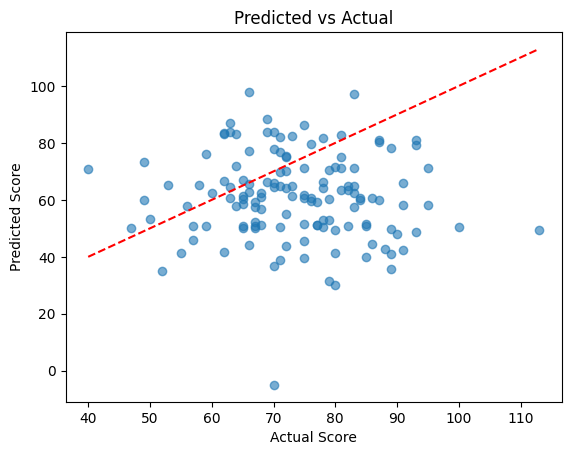

Epoch 1, Loss: 446.1871
Epoch 2, Loss: 440.0348
Epoch 3, Loss: 396.3746
Epoch 4, Loss: 455.0992
Epoch 5, Loss: 434.1635
Epoch 6, Loss: 334.0974
Epoch 7, Loss: 281.3223
Epoch 8, Loss: 410.4629
Epoch 9, Loss: 283.3010
Epoch 10, Loss: 328.8896
Epoch 11, Loss: 275.9662
Epoch 12, Loss: 332.7066
Epoch 13, Loss: 400.4100
Epoch 14, Loss: 339.0488
Epoch 15, Loss: 321.9522
Epoch 16, Loss: 396.9604
Epoch 17, Loss: 172.5379
Epoch 18, Loss: 370.1078
Epoch 19, Loss: 386.9304
Epoch 20, Loss: 230.7158
Epoch 21, Loss: 390.8806
Epoch 22, Loss: 229.0352
Epoch 23, Loss: 287.6052
Epoch 24, Loss: 262.3727
Epoch 25, Loss: 355.8690
Epoch 26, Loss: 223.2953
Epoch 27, Loss: 228.7475
Epoch 28, Loss: 284.7840
Epoch 29, Loss: 188.4991
Epoch 30, Loss: 443.1667
Epoch 31, Loss: 260.8541
Epoch 32, Loss: 264.8225
Epoch 33, Loss: 200.4445
Epoch 34, Loss: 228.0686
Epoch 35, Loss: 208.5638
Epoch 36, Loss: 229.7986
Epoch 37, Loss: 245.2896
Epoch 38, Loss: 388.8785
Epoch 39, Loss: 258.7070
Epoch 40, Loss: 385.3179
Epoch 41,

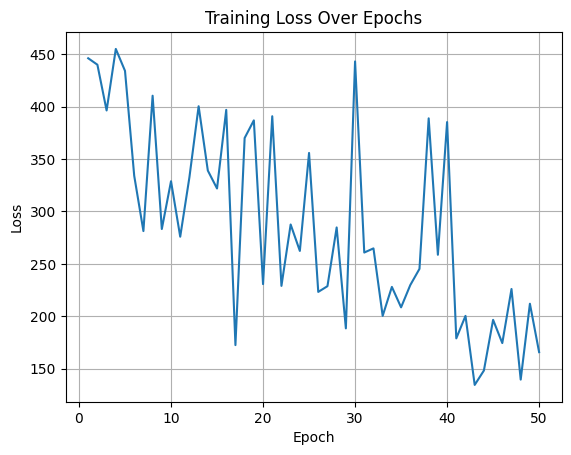

Feature 0: Weight = -0.1876
Feature 1: Weight = -0.0444
Feature 2: Weight = -0.2328
Feature 3: Weight = 0.0402
Feature 4: Weight = -0.1990
Feature 5: Weight = -0.1527
Feature 6: Weight = -0.1231
Feature 7: Weight = 0.1110
Feature 8: Weight = 0.0250
Feature 9: Weight = -0.1509
Feature 10: Weight = 0.0587
Feature 11: Weight = 0.0835
Feature 12: Weight = -0.0640
Feature 13: Weight = -0.1579
Feature 14: Weight = 0.0427
Bias term: -0.1567
Test RMSE: 23.36
Test R-Squared Score: -2.9560


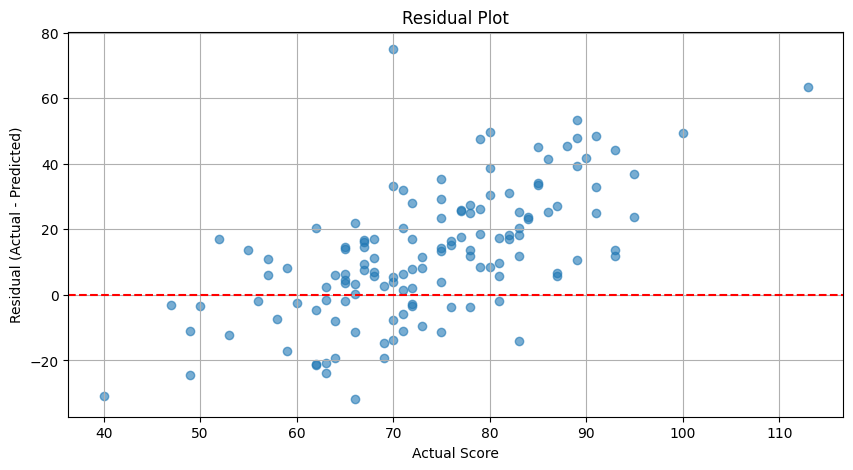

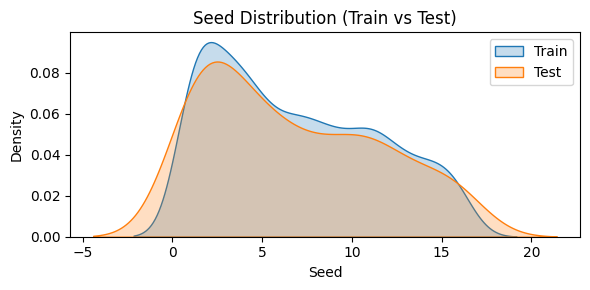

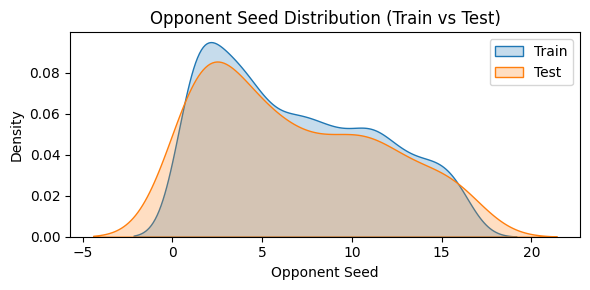

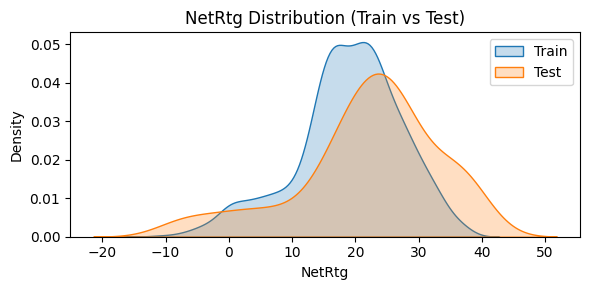

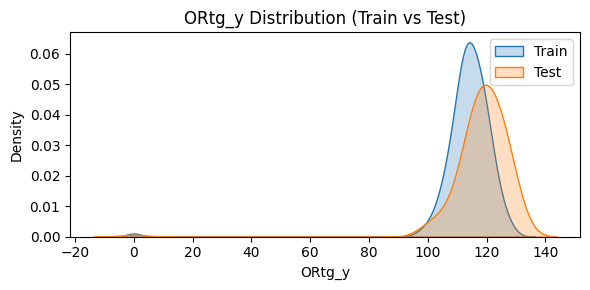

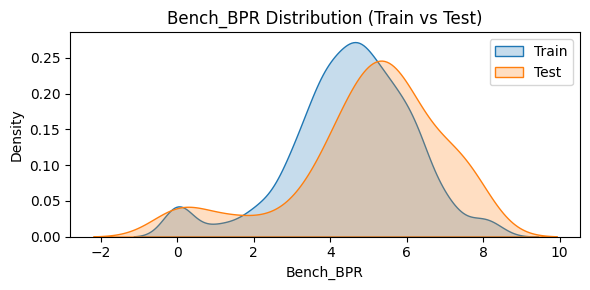

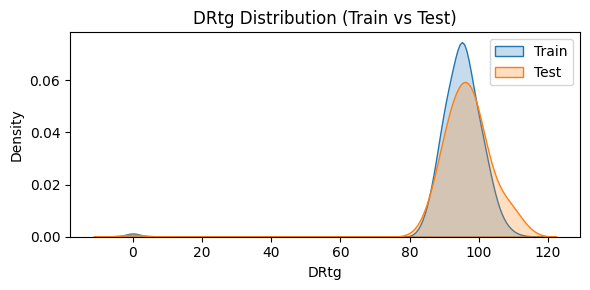

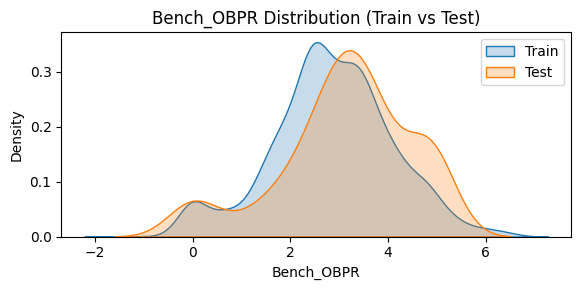

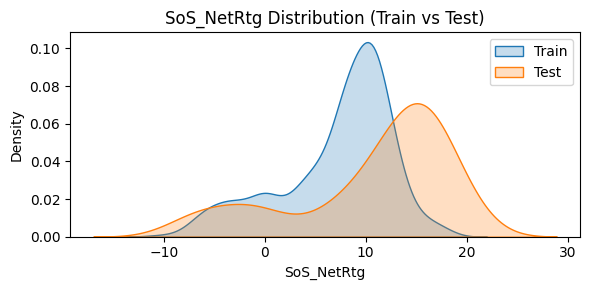

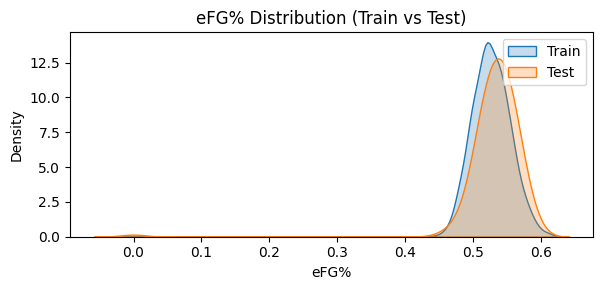

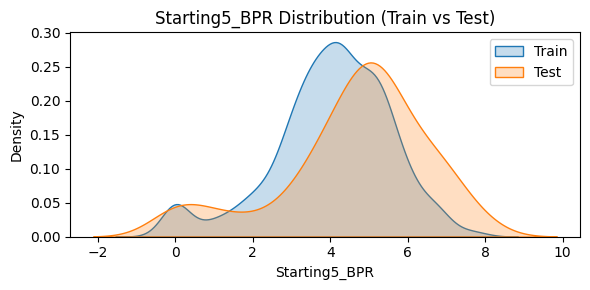

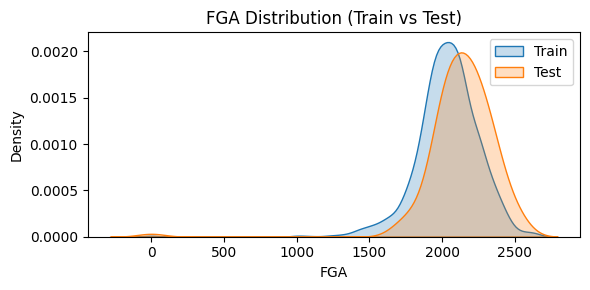

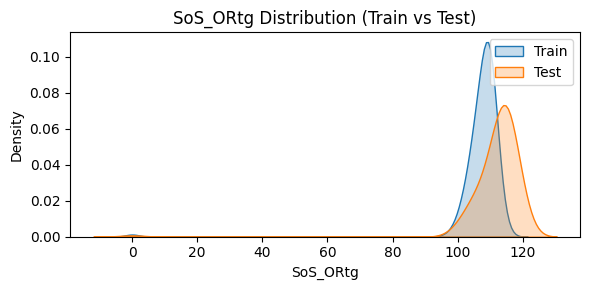

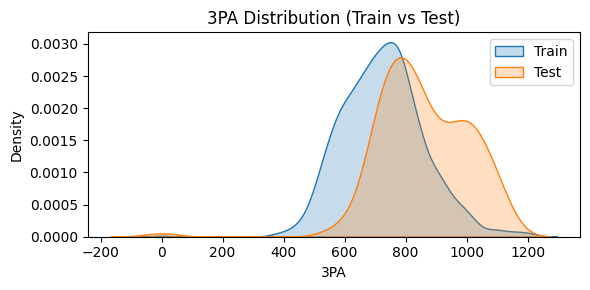

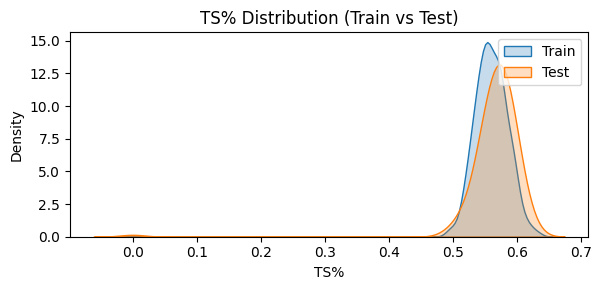

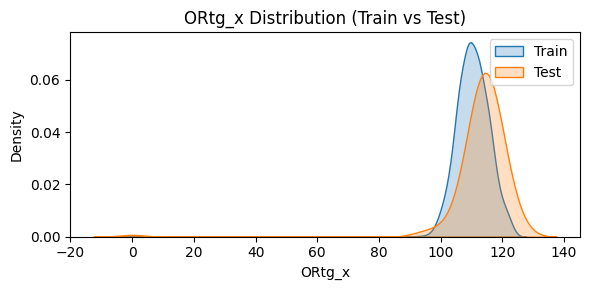

In [9]:
# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Plot the loss Curve
losses = []

for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())  # Track the final batch loss per epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# 🔍 Plotting
plt.plot(range(1, 51), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

# Model Weights and Bias
weights = model.linear.weight.data.cpu().numpy().flatten()
bias = model.linear.bias.data.item()

for i, w in enumerate(weights):
    print(f"Feature {i}: Weight = {w:.4f}")
print(f"Bias term: {bias:.4f}")

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

# plot residuals
residuals = actuals_np - preds_np

plt.figure(figsize=(10, 5))
plt.scatter(actuals_np, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Drift features
drift_features = ['Seed', 'Opponent Seed', 'NetRtg', 'ORtg_y', 'Bench_BPR', 'DRtg', 'Bench_OBPR', 'SoS_NetRtg', 'eFG%', 'Starting5_BPR', 'FGA', 
                  'SoS_ORtg', '3PA', 'TS%', 'ORtg_x']

for col in drift_features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(x_train_linear_feature_importance_ds[col], label="Train", fill=True)
    sns.kdeplot(x_test_linear_feature_importance_ds[col], label="Test", fill=True)
    plt.title(f"{col} Distribution (Train vs Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# First pass results not good.  Showing an error of 11 points per prediction.  At this point, only about 18% of variance is explained by my features. Less see if we can figure out why

From looking at the graphs it looks like there is a much different curve for the distributions for the 2025 year.  I am wondering if scalling the x features will help with these issues. 

tensor([[ 0.1092],
        [ 0.0404],
        [-0.1323],
        [-0.2348],
        [-0.3624]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 1, Loss: 4706.0405
Epoch 2, Loss: 5433.1201
Epoch 3, Loss: 4552.3740
Epoch 4, Loss: 4531.6680
Epoch 5, Loss: 4794.9961
Epoch 6, Loss: 4872.9238
Epoch 7, Loss: 4549.6851
Epoch 8, Loss: 5411.0771
Epoch 9, Loss: 5059.4570
Epoch 10, Loss: 5277.5171
Epoch 11, Loss: 4756.5649
Epoch 12, Loss: 5407.4092
Epoch 13, Loss: 4466.5151
Epoch 14, Loss: 4898.6802
Epoch 15, Loss: 5500.9058
Epoch 16, Loss: 4965.8354
Epoch 17, Loss: 4656.3574
Epoch 18, Loss: 5409.7354
Epoch 19, Loss: 4661.7588
Epoch 20, Loss: 5119.0459
Epoch 21, Loss: 5092.2725
Epoch 22, Loss: 4772.9092
Epoch 23, Loss: 4655.9834
Epoch 24, Loss: 4949.8159
Epoch 25, Loss: 5044.4648
Epoch 26, Loss: 4709.3218
Epoch 27, Loss: 5173.3066
Epoch 28, Loss: 5015.9990
Epoch 29, Loss: 4993.4951
Epoch 30, Loss: 5252.2139
Epoch 31, Loss: 5260.5552
Epoch 32, Loss: 4954.2681
Epoch 33, Loss: 4625.0732
Epoch 34, Lo

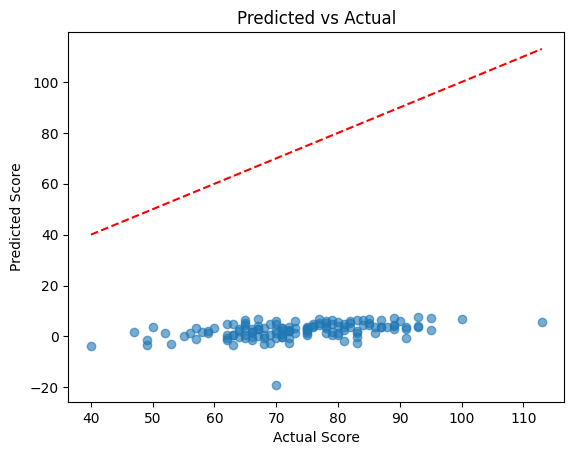

Test RMSE: 72.02
Test R-Squared Score: -36.5857


In [10]:
# Clear out Old Model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Second Run with Scaled Features
scaler = StandardScaler()

# Fit on training set only
x_train_linear_feature_importance_ds_scaled = pd.DataFrame(scaler.fit_transform(x_train_linear_feature_importance_ds),
                                                           columns=x_train_linear_feature_importance_ds.columns,
                                                           index=x_train_linear_feature_importance_ds.index)

# Transform test set using fitted scaler
x_test_linear_feature_importance_ds_scaled = pd.DataFrame(scaler.transform(x_test_linear_feature_importance_ds),
                                                          columns=x_test_linear_feature_importance_ds.columns,
                                                          index=x_test_linear_feature_importance_ds.index)

# Set Dimensions (# of features and outputs)
input_dim = x_train_linear_feature_importance_ds_scaled.shape[1]
output_dim = 1

model = Net(input_dim=x_train_linear_feature_importance_ds_scaled.shape[1], hidden_dim=64, output_dim=1).to(device)

x_sample = torch.randn(5, input_dim).to(device)  # Initial Condition of 5

# 🧪 Forward pass
output = model(x_sample)
print(output)

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled.values, dtype=torch.float32)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Training loop
for epoch in range(50):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

Going to take try a different optimizer for this.  SGD and Adagrad, with the standard data.  

Epoch 1, Loss: 248828.0469
Epoch 2, Loss: 186659.5469
Epoch 3, Loss: 139684.1562
Epoch 4, Loss: 96108.8125
Epoch 5, Loss: 62573.4609
Epoch 6, Loss: 46572.1602
Epoch 7, Loss: 26655.9844
Epoch 8, Loss: 18932.4863
Epoch 9, Loss: 11454.0312
Epoch 10, Loss: 6175.5557
Epoch 11, Loss: 3261.2456
Epoch 12, Loss: 1729.1904
Epoch 13, Loss: 1318.5651
Epoch 14, Loss: 657.6896
Epoch 15, Loss: 307.3744
Epoch 16, Loss: 304.7156
Epoch 17, Loss: 230.2850
Epoch 18, Loss: 390.8610
Epoch 19, Loss: 389.2315
Epoch 20, Loss: 321.2499
Epoch 21, Loss: 269.8346
Epoch 22, Loss: 149.9153
Epoch 23, Loss: 219.0390
Epoch 24, Loss: 187.5551
Epoch 25, Loss: 213.9897
Epoch 26, Loss: 315.0758
Epoch 27, Loss: 303.7363
Epoch 28, Loss: 173.8180
Epoch 29, Loss: 206.9344
Epoch 30, Loss: 326.2817
Epoch 31, Loss: 235.9660
Epoch 32, Loss: 276.0549
Epoch 33, Loss: 173.0047
Epoch 34, Loss: 202.6569
Epoch 35, Loss: 233.3350
Epoch 36, Loss: 181.8834
Epoch 37, Loss: 235.0231
Epoch 38, Loss: 184.5423
Epoch 39, Loss: 286.8338
Epoch 40,

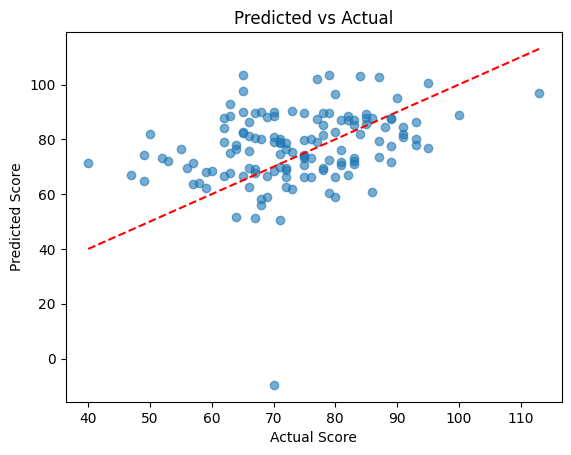

Test RMSE: 15.50
Test R-Squared Score: -0.7408


In [11]:
# Convert training loop into a function (first change)
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

Epoch 1, Loss: 235.6383
Epoch 2, Loss: 328.7515
Epoch 3, Loss: 383.0618
Epoch 4, Loss: 426.2464
Epoch 5, Loss: 432.0782
Epoch 6, Loss: 268.6656
Epoch 7, Loss: 325.9625
Epoch 8, Loss: 339.4459
Epoch 9, Loss: 318.2519
Epoch 10, Loss: 250.0591
Epoch 11, Loss: 378.8556
Epoch 12, Loss: 746.8153
Epoch 13, Loss: 495.5958
Epoch 14, Loss: 252.9933
Epoch 15, Loss: 410.7883
Epoch 16, Loss: 213.9828
Epoch 17, Loss: 309.9845
Epoch 18, Loss: 225.6931
Epoch 19, Loss: 408.2888
Epoch 20, Loss: 336.9576
Epoch 21, Loss: 389.8293
Epoch 22, Loss: 346.3590
Epoch 23, Loss: 301.6144
Epoch 24, Loss: 228.0682
Epoch 25, Loss: 257.4385
Epoch 26, Loss: 303.2574
Epoch 27, Loss: 256.2405
Epoch 28, Loss: 275.3601
Epoch 29, Loss: 172.4709
Epoch 30, Loss: 287.6454
Epoch 31, Loss: 240.2413
Epoch 32, Loss: 183.9555
Epoch 33, Loss: 416.4162
Epoch 34, Loss: 170.9015
Epoch 35, Loss: 199.4001
Epoch 36, Loss: 249.1321
Epoch 37, Loss: 220.3643
Epoch 38, Loss: 175.7845
Epoch 39, Loss: 261.6855
Epoch 40, Loss: 230.8995
Epoch 41,

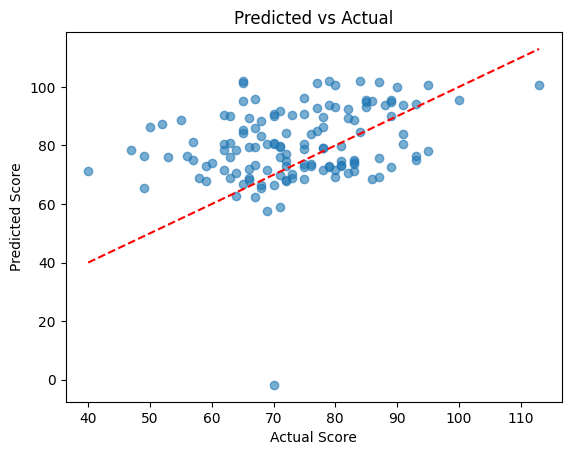

Test RMSE: 16.19
Test R-Squared Score: -0.8993


In [12]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
# Made Optimizer change to Adagrad
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2) 
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

linear.weight: NaNs=0, Max=0.2129
linear.bias: NaNs=0, Max=0.2517
None
Epoch 1, Loss: 12846.0674
Epoch 2, Loss: 3882.1521
Epoch 3, Loss: 416.7520
Epoch 4, Loss: 332.3975
Epoch 5, Loss: 429.5494
Epoch 6, Loss: 367.7723
Epoch 7, Loss: 340.7902
Epoch 8, Loss: 291.1178
Epoch 9, Loss: 462.5419
Epoch 10, Loss: 288.3004
Epoch 11, Loss: 284.8642
Epoch 12, Loss: 214.6089
Epoch 13, Loss: 245.3321
Epoch 14, Loss: 163.8916
Epoch 15, Loss: 162.9679
Epoch 16, Loss: 254.1209
Epoch 17, Loss: 170.6850
Epoch 18, Loss: 110.6162
Epoch 19, Loss: 156.3029
Epoch 20, Loss: 172.3147
Epoch 21, Loss: 144.3386
Epoch 22, Loss: 180.2587
Epoch 23, Loss: 224.8313
Epoch 24, Loss: 176.2997
Epoch 25, Loss: 144.0168
Epoch 26, Loss: 103.1227
Epoch 27, Loss: 86.5282
Epoch 28, Loss: 157.5765
Epoch 29, Loss: 124.1623
Epoch 30, Loss: 103.3877
Epoch 31, Loss: 149.6407
Epoch 32, Loss: 139.4169
Epoch 33, Loss: 206.8634
Epoch 34, Loss: 97.6445
Epoch 35, Loss: 207.0993
Epoch 36, Loss: 238.0543
Epoch 37, Loss: 166.0044
Epoch 38, Lo

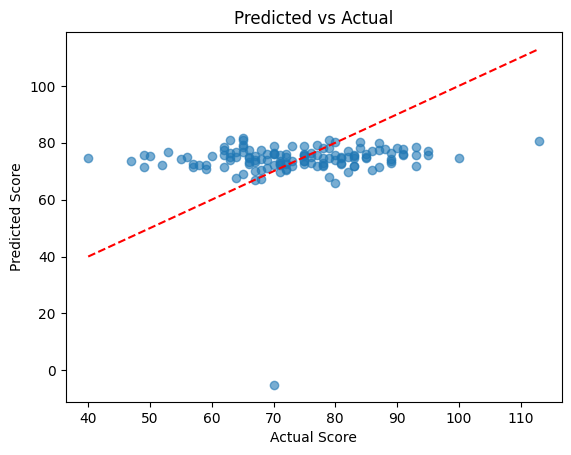

Test RMSE: 13.35
Test R-Squared Score: -0.2911
linear.weight: NaNs=0, Max=0.2433
linear.bias: NaNs=0, Max=0.0794


In [13]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # attempt to keep gradients from exploding as they did in first trials with SGD
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

print(check_weights(model))

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
# Made Optimizer change to SGD
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9) # started at a lr of 1e-3, but returned NaN so slowing it down
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")


def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

check_weights(model)


linear.weight: NaNs=0, Max=0.2484
linear.bias: NaNs=0, Max=0.1553
None
Epoch 1, Loss: 18298.0234
Epoch 2, Loss: 469.0566
Epoch 3, Loss: 149.0395
Epoch 4, Loss: 83.9147
Epoch 5, Loss: 103.0906
Epoch 6, Loss: 128.0952
Epoch 7, Loss: 161.2466
Epoch 8, Loss: 128.5981
Epoch 9, Loss: 107.6500
Epoch 10, Loss: 106.1732
Epoch 11, Loss: 389.8374
Epoch 12, Loss: 134.4290
Epoch 13, Loss: 118.2097
Epoch 14, Loss: 115.5290
Epoch 15, Loss: 143.3772
Epoch 16, Loss: 185.7422
Epoch 17, Loss: 173.2934
Epoch 18, Loss: 222.8903
Epoch 19, Loss: 116.4269
Epoch 20, Loss: 155.0758
Epoch 21, Loss: 153.9178
Epoch 22, Loss: 189.3656
Epoch 23, Loss: 146.4874
Epoch 24, Loss: 105.3141
Epoch 25, Loss: 315.2728
Epoch 26, Loss: 160.5765
Epoch 27, Loss: 159.6057
Epoch 28, Loss: 181.4358
Epoch 29, Loss: 148.4287
Epoch 30, Loss: 123.8371
Epoch 31, Loss: 125.5731
Epoch 32, Loss: 179.1806
Epoch 33, Loss: 165.1918
Epoch 34, Loss: 99.4463
Epoch 35, Loss: 138.4659
Epoch 36, Loss: 155.4365
Epoch 37, Loss: 119.7441
Epoch 38, Los

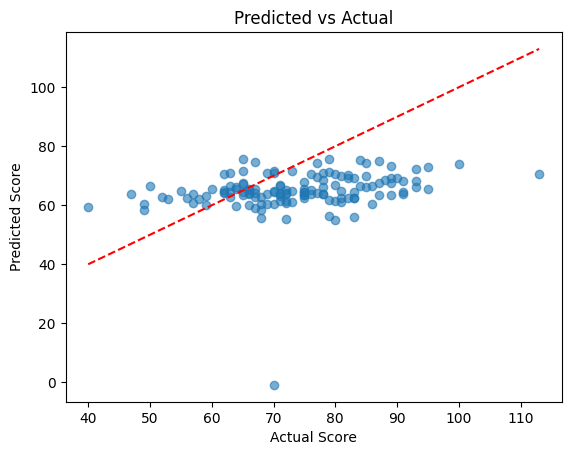

Test RMSE: 15.02
Test R-Squared Score: -0.6356


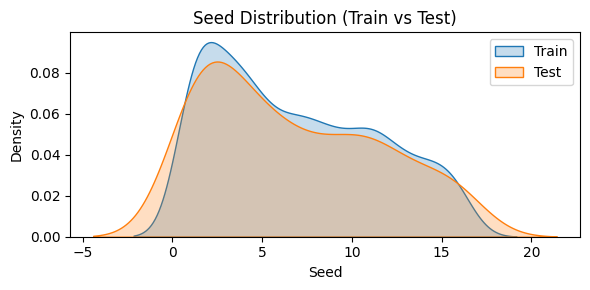

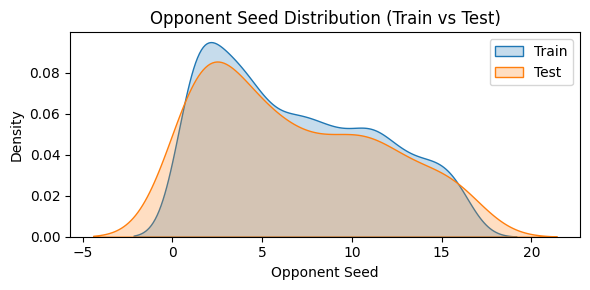

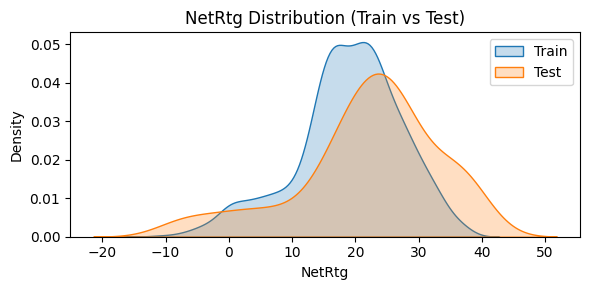

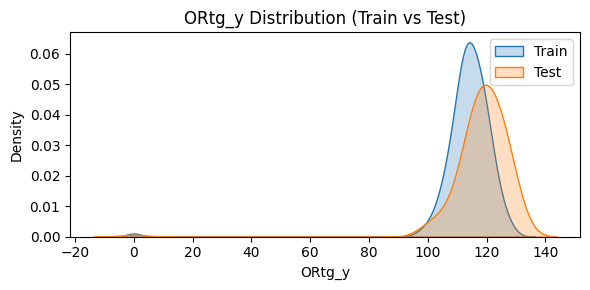

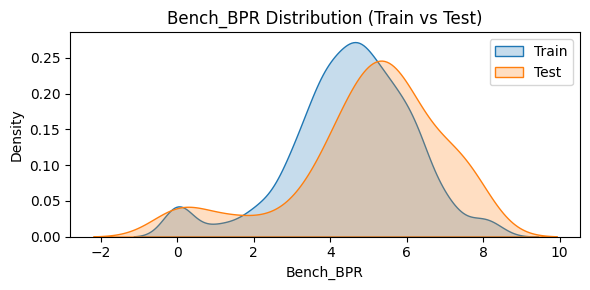

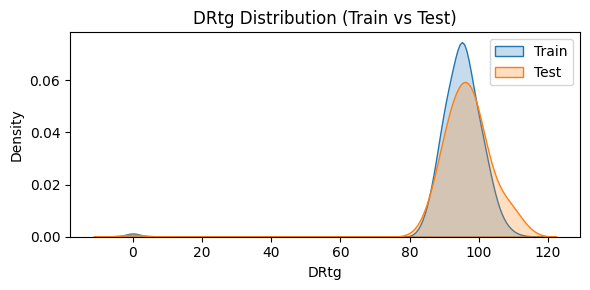

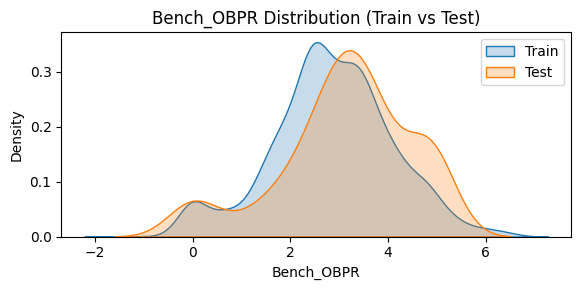

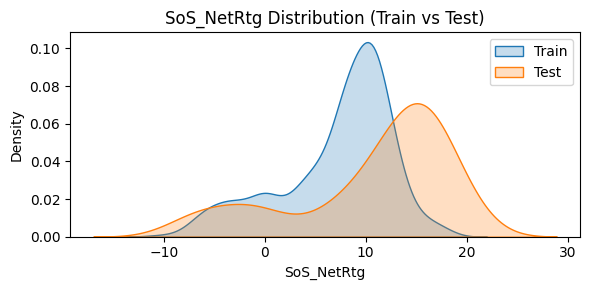

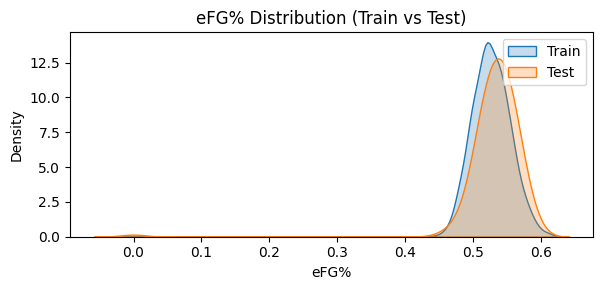

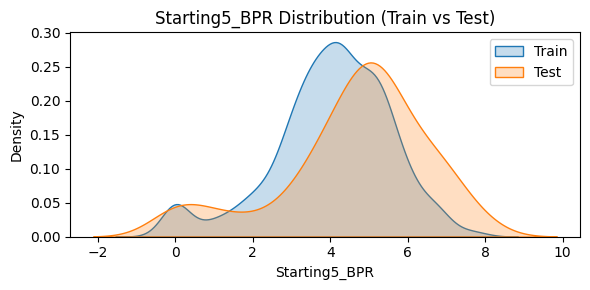

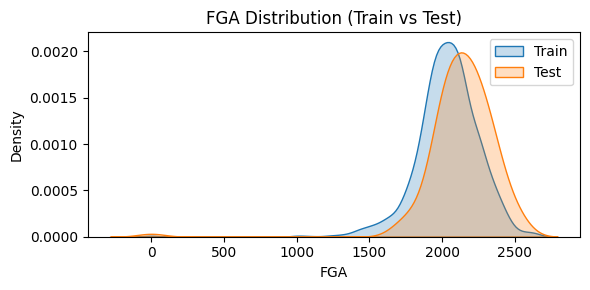

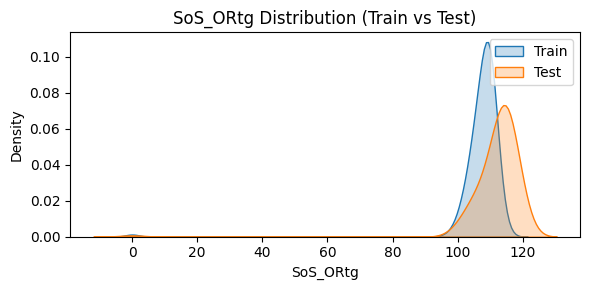

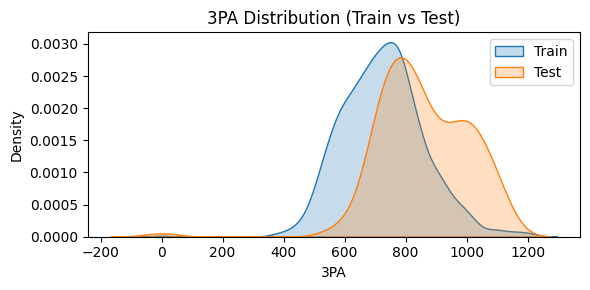

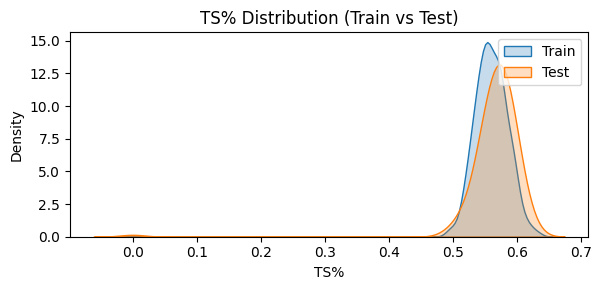

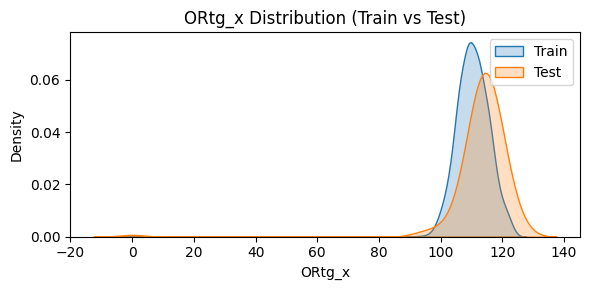

linear.weight: NaNs=0, Max=0.3069
linear.bias: NaNs=0, Max=0.0383


In [14]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(linact_linfea_data):
    for name, param in linact_linfea_data.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

linact_linfea_data = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
print(check_weights(linact_linfea_data))

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

linact_linfea_data = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device) # Save this Model Using Pickle for Modeling

model_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\linact_linfea_data.pkl"
with open(model_path, "wb") as f: pickle.dump(linact_linfea_data, f)
    
# Save using different method for Pytorch Model in case pickle does not work due to CUDA issues 
model_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\linact_linfea_data.pth"
torch.save(linact_linfea_data.state_dict(), model_path)

# Made Optimizer change to SGD
optimizer = torch.optim.SGD(linact_linfea_data.parameters(), lr=1e-3, momentum=0.9) # move back up to -3
criterion = torch.nn.MSELoss()
loss_history = train_model(linact_linfea_data, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
linact_linfea_data.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = linact_linfea_data(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

drift_features = ['Seed', 'Opponent Seed', 'NetRtg', 'ORtg_y', 'Bench_BPR', 'DRtg', 'Bench_OBPR', 'SoS_NetRtg', 'eFG%', 
                   'Starting5_BPR', 'FGA', 'SoS_ORtg', '3PA', 'TS%', 'ORtg_x']

for col in drift_features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(x_train_linear_feature_importance_ds[col], label="Train", fill=True)
    sns.kdeplot(x_test_linear_feature_importance_ds[col], label="Test", fill=True)
    plt.title(f"{col} Distribution (Train vs Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def check_weights(linact_linfea_data):
    for name, param in linact_linfea_data.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

check_weights(linact_linfea_data)

Run same models with Adam, SGD, Adagrad on the round_trend_analysis dataset

linear.weight: NaNs=0, Max=0.1819
linear.bias: NaNs=0, Max=0.1762
Epoch 1, Loss: 317778.4062
Epoch 2, Loss: 60597.7109
Epoch 3, Loss: 12756.2861
Epoch 4, Loss: 1383.1399
Epoch 5, Loss: 703.6328
Epoch 6, Loss: 427.6988
Epoch 7, Loss: 809.8928
Epoch 8, Loss: 380.1341
Epoch 9, Loss: 427.4624
Epoch 10, Loss: 351.6987
Epoch 11, Loss: 308.8728
Epoch 12, Loss: 369.8429
Epoch 13, Loss: 377.2781
Epoch 14, Loss: 252.3491
Epoch 15, Loss: 362.6436
Epoch 16, Loss: 191.5165
Epoch 17, Loss: 215.7184
Epoch 18, Loss: 221.5331
Epoch 19, Loss: 261.3990
Epoch 20, Loss: 188.9969
Epoch 21, Loss: 294.3777
Epoch 22, Loss: 190.8386
Epoch 23, Loss: 182.8286
Epoch 24, Loss: 174.2004
Epoch 25, Loss: 140.8413
Epoch 26, Loss: 174.8326
Epoch 27, Loss: 250.6335
Epoch 28, Loss: 115.1731
Epoch 29, Loss: 168.3493
Epoch 30, Loss: 173.8812
Epoch 31, Loss: 190.3622
Epoch 32, Loss: 123.1504
Epoch 33, Loss: 126.8491
Epoch 34, Loss: 230.8716
Epoch 35, Loss: 155.4164
Epoch 36, Loss: 110.2173
Epoch 37, Loss: 151.7692
Epoch 38, 

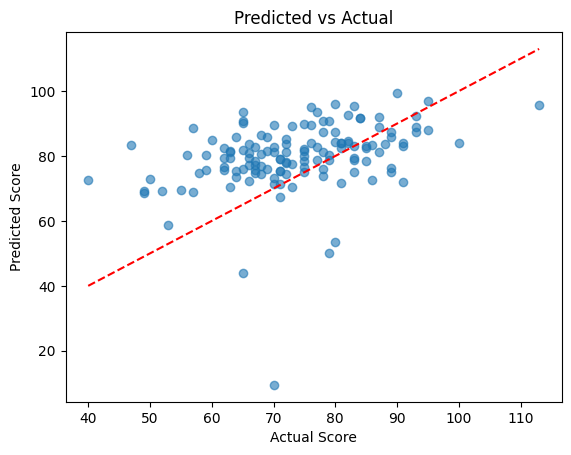

Test RMSE: 14.31
Test R-Squared Score: -0.4850
linear.weight: NaNs=0, Max=0.4340
linear.bias: NaNs=0, Max=0.3448


In [15]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_round_tend_analysis_features_ds.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_round_tend_analysis_features_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create model
model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)

# Check initial weights (MOVED AFTER model creation)
check_weights(model)

# Setup optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Train model
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - FIXED: Use consistent y_test_tensor
y_test_tensor = y_test_tensor.to(device)  # Use the one we already created
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')
plt.show()

# Compute metrics - FIXED: Use the same y_test_tensor
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")

# Check final weights
check_weights(model)

Epoch 1, Loss: 18127.8457
Epoch 2, Loss: 364.4291
Epoch 3, Loss: 277.3006
Epoch 4, Loss: 435.5270
Epoch 5, Loss: 296.1694
Epoch 6, Loss: 223.0986
Epoch 7, Loss: 172.2535
Epoch 8, Loss: 242.3045
Epoch 9, Loss: 458.7076
Epoch 10, Loss: 190.4327
Epoch 11, Loss: 227.6434
Epoch 12, Loss: 444.8122
Epoch 13, Loss: 306.1609
Epoch 14, Loss: 191.0809
Epoch 15, Loss: 577.3640
Epoch 16, Loss: 175.4149
Epoch 17, Loss: 135.5140
Epoch 18, Loss: 465.4048
Epoch 19, Loss: 237.8999
Epoch 20, Loss: 260.9420
Epoch 21, Loss: 230.6446
Epoch 22, Loss: 521.2328
Epoch 23, Loss: 348.0592
Epoch 24, Loss: 343.7133
Epoch 25, Loss: 340.7054
Epoch 26, Loss: 139.6558
Epoch 27, Loss: 411.9592
Epoch 28, Loss: 193.1993
Epoch 29, Loss: 211.4633
Epoch 30, Loss: 241.1549
Epoch 31, Loss: 179.8361
Epoch 32, Loss: 234.2219
Epoch 33, Loss: 350.8535
Epoch 34, Loss: 252.8680
Epoch 35, Loss: 451.9071
Epoch 36, Loss: 557.0638
Epoch 37, Loss: 154.7590
Epoch 38, Loss: 324.2668
Epoch 39, Loss: 414.5192
Epoch 40, Loss: 220.0766
Epoch 4

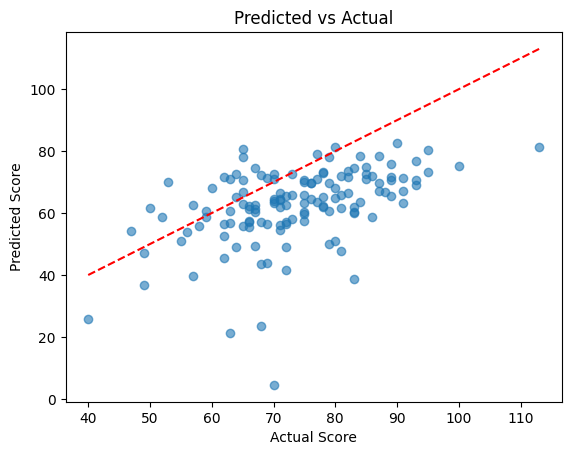

Test RMSE: 16.48
Test R-Squared Score: -0.9675
linear.weight: NaNs=0, Max=0.1850
linear.bias: NaNs=0, Max=0.0006


In [16]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # attempt to keep gradients from exploding as they did in first trials with SGD
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_round_tend_analysis_features_ds .values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_round_tend_analysis_features_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
# Made Optimizer change to SGD
optimizer =  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")


def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

check_weights(model)

Epoch 1, Loss: 70594.3984
Epoch 2, Loss: 8099.2847
Epoch 3, Loss: 594.6161
Epoch 4, Loss: 600.0478
Epoch 5, Loss: 666.3364
Epoch 6, Loss: 618.4464
Epoch 7, Loss: 435.6346
Epoch 8, Loss: 466.4900
Epoch 9, Loss: 469.2544
Epoch 10, Loss: 728.7872
Epoch 11, Loss: 346.7259
Epoch 12, Loss: 432.1556
Epoch 13, Loss: 656.6270
Epoch 14, Loss: 554.6396
Epoch 15, Loss: 251.8694
Epoch 16, Loss: 290.2119
Epoch 17, Loss: 335.3012
Epoch 18, Loss: 507.1396
Epoch 19, Loss: 342.4365
Epoch 20, Loss: 196.8250
Epoch 21, Loss: 166.6630
Epoch 22, Loss: 200.2827
Epoch 23, Loss: 302.1838
Epoch 24, Loss: 269.5428
Epoch 25, Loss: 316.5808
Epoch 26, Loss: 241.6718
Epoch 27, Loss: 230.9966
Epoch 28, Loss: 245.1971
Epoch 29, Loss: 330.8079
Epoch 30, Loss: 280.2913
Epoch 31, Loss: 210.3201
Epoch 32, Loss: 147.2681
Epoch 33, Loss: 190.7822
Epoch 34, Loss: 224.0799
Epoch 35, Loss: 215.9028
Epoch 36, Loss: 226.1901
Epoch 37, Loss: 210.3822
Epoch 38, Loss: 224.9211
Epoch 39, Loss: 130.8905
Epoch 40, Loss: 210.9149
Epoch 

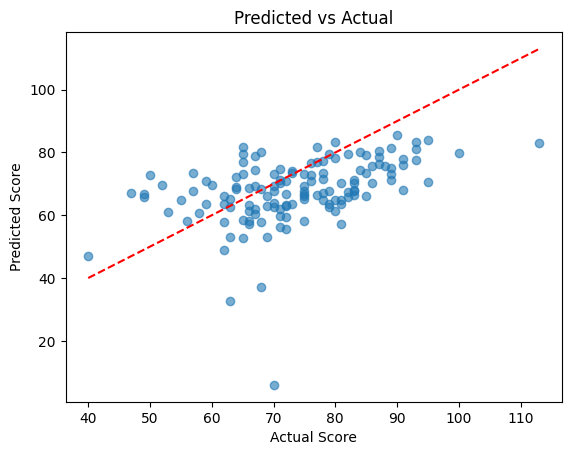

Test RMSE: 13.10
Test R-Squared Score: -0.2436
linear.weight: NaNs=0, Max=0.2933
linear.bias: NaNs=0, Max=0.0234


In [17]:
def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # attempt to keep gradients from exploding as they did in first trials with SGD
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_round_tend_analysis_features_ds .values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_round_tend_analysis_features_ds.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device)
# Made Optimizer change to SGD
optimizer =  torch.optim.Adagrad(model.parameters(), lr=1e-2) 
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_round_tend_analysis_features_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")


def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

check_weights(model)

Epoch 1, Loss: 877.3931
Epoch 2, Loss: 211.6655
Epoch 3, Loss: 342.5797
Epoch 4, Loss: 183.1375
Epoch 5, Loss: 181.2762
Epoch 6, Loss: 367.6276
Epoch 7, Loss: 227.2541
Epoch 8, Loss: 115.2878
Epoch 9, Loss: 165.5325
Epoch 10, Loss: 138.6489
Epoch 11, Loss: 133.8671
Epoch 12, Loss: 213.2418
Epoch 13, Loss: 158.6070
Epoch 14, Loss: 137.2500
Epoch 15, Loss: 167.8705
Epoch 16, Loss: 149.7961
Epoch 17, Loss: 235.9563
Epoch 18, Loss: 224.6514
Epoch 19, Loss: 178.1644
Epoch 20, Loss: 78.6723
Epoch 21, Loss: 138.3913
Epoch 22, Loss: 263.3734
Epoch 23, Loss: 165.1238
Epoch 24, Loss: 191.6525
Epoch 25, Loss: 164.1723
Epoch 26, Loss: 116.5919
Epoch 27, Loss: 181.4909
Epoch 28, Loss: 133.8328
Epoch 29, Loss: 145.3325
Epoch 30, Loss: 137.1736
Epoch 31, Loss: 185.3240
Epoch 32, Loss: 144.9232
Epoch 33, Loss: 160.3289
Epoch 34, Loss: 143.9171
Epoch 35, Loss: 124.2217
Epoch 36, Loss: 140.5868
Epoch 37, Loss: 111.8656
Epoch 38, Loss: 93.6795
Epoch 39, Loss: 150.1249
Epoch 40, Loss: 108.2302
Epoch 41, L

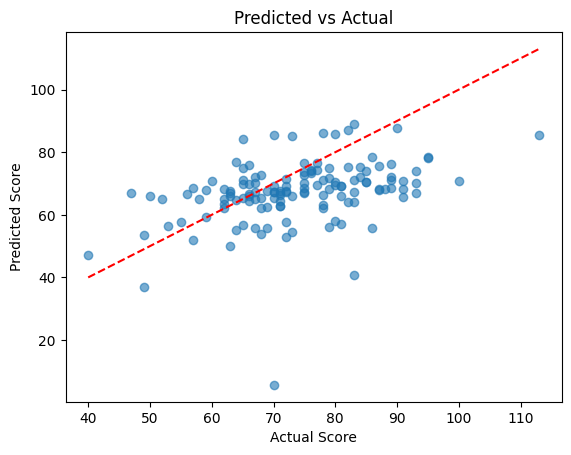

Test RMSE: 13.70
Test R-Squared Score: -0.3612
linear.weight: NaNs=0, Max=0.2496
linear.bias: NaNs=0, Max=0.1012


In [18]:
# Create Test and Train Sets
test_bracket_data_set = bracket_data_set[(bracket_data_set["Year"] == 2025)]
train_bracket_data_set = bracket_data_set[(bracket_data_set["Year"] < 2025)]

dropped_columns_train = train_bracket_data_set[['Year', 'Score', 'Team', 'Result', 'Champion' ]]
dropped_columns_test = test_bracket_data_set[['Year', 'Score', 'Team', 'Result', 'Champion' ]]

x_train_bracket_data_set = train_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion' ])
y_train_bracket_data_set = train_bracket_data_set['Score']
x_test_bracket_data_set = test_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion' ])
y_test_bracket_data_set = test_bracket_data_set['Score']


def train_model(model, optimizer, criterion, train_loader, device, epochs=50):
    loss_history = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # attempt to keep gradients from exploding as they did in first trials with SGD
            optimizer.step()

        loss_history.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return loss_history

def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

# Clean and setup tensors
x_train_tensor = torch.tensor(x_train_bracket_data_set.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bracket_data_set.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_bracket_data_set.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_bracket_data_set.values, dtype=torch.float32).view(-1, 1)

# Load data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LinearModel(input_dim=x_train_tensor.shape[1], output_dim=1).to(device) # Save this Linear Activation Model - Rename

# Made Optimizer change to SGD
optimizer =  torch.optim.Adagrad(model.parameters(), lr=1e-2) 
criterion = torch.nn.MSELoss()
loss_history = train_model(model, optimizer, criterion, train_loader, device, epochs=50)

# Test Model with 2025 data
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    score_preds = model(x_test_tensor)

# Plot the Predicted vs Actual - How did we do?
y_test_tensor = torch.tensor(y_test_bracket_data_set.values, dtype=torch.float32).view(-1, 1).to(device)

# Convert predictions to CPU for plotting
preds_np = score_preds.cpu().numpy()
actuals_np = y_test_tensor.cpu().numpy()

plt.scatter(actuals_np, preds_np, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')  # Identity line
plt.show()

# Compute RMSE and R-Squared
y_test_tensor = torch.tensor(y_test_bracket_data_set.values, dtype=torch.float32).view(-1, 1).to(device)

# Compute metrics
mse = mean_squared_error(y_test_tensor.cpu(), score_preds.cpu())
rmse = np.sqrt(mse)

r2 = r2_score(y_test_tensor.cpu(), score_preds.cpu())

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-Squared Score: {r2:.4f}")


def check_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}: NaNs={torch.isnan(param).sum().item()}, Max={param.abs().max().item():.4f}")

check_weights(model)

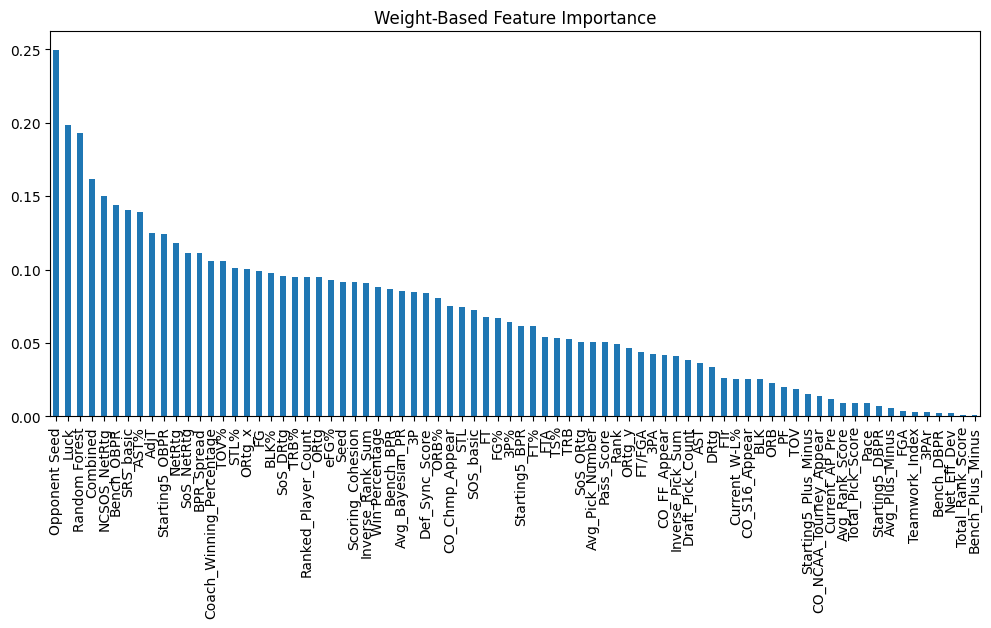

In [19]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

with torch.no_grad():
    first_layer_weights = model.linear.weight.abs().flatten()
    feature_importance = pd.Series(first_layer_weights.cpu().numpy(), index=x_train_bracket_data_set.columns)
    feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Weight-Based Feature Importance")

<Axes: title={'center': 'Permutation Importance'}>

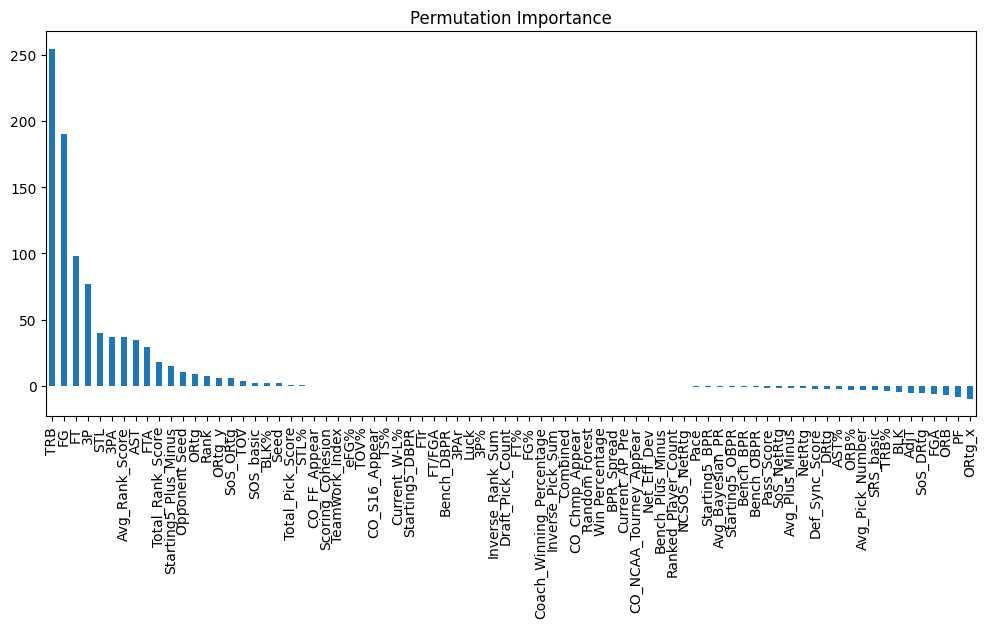

In [20]:
class TorchRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device

    def fit(self, X, y):  # Not used but required for compatibility
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy().flatten()
        return preds

wrapped_model = TorchRegressorWrapper(model=model, device=device)

results = permutation_importance(
    estimator=wrapped_model,
    X=x_test_bracket_data_set,
    y=y_test_bracket_data_set,
    n_repeats=10,
    scoring='neg_mean_squared_error',
    random_state=42
)

importance_scores = pd.Series(results.importances_mean, index=x_test_bracket_data_set.columns)
importance_scores.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Permutation Importance")

Non of the Linear Activation Models produced viable models.  Either scaled or unscaled. Running this model with all the features still did not produce any good models.  Some of the Linear Regression Features were present in the permutation Import. 
# Moving forward to Neural Networks

Epoch 1/100 | Train Loss: 639.5422 | Test RMSE: 21.0036 | R²: -2.1971
Epoch 6/100 | Train Loss: 296.0580 | Test RMSE: 16.2637 | R²: -0.9170
Epoch 11/100 | Train Loss: 288.8073 | Test RMSE: 17.9548 | R²: -1.3363
Epoch 16/100 | Train Loss: 252.8055 | Test RMSE: 19.5145 | R²: -1.7599
Epoch 21/100 | Train Loss: 250.0566 | Test RMSE: 16.7290 | R²: -1.0282
Epoch 26/100 | Train Loss: 251.6469 | Test RMSE: 19.4970 | R²: -1.7549
Epoch 31/100 | Train Loss: 237.7237 | Test RMSE: 15.9466 | R²: -0.8429
Epoch 36/100 | Train Loss: 241.1739 | Test RMSE: 19.4127 | R²: -1.7312
Epoch 41/100 | Train Loss: 238.6223 | Test RMSE: 18.8450 | R²: -1.5737
Epoch 46/100 | Train Loss: 242.2638 | Test RMSE: 19.4218 | R²: -1.7337
Epoch 51/100 | Train Loss: 239.4829 | Test RMSE: 19.1483 | R²: -1.6572
Epoch 56/100 | Train Loss: 243.6015 | Test RMSE: 19.0583 | R²: -1.6323
Epoch 61/100 | Train Loss: 234.4091 | Test RMSE: 19.0997 | R²: -1.6438
Epoch 66/100 | Train Loss: 242.7363 | Test RMSE: 18.9389 | R²: -1.5995
Epoch 71

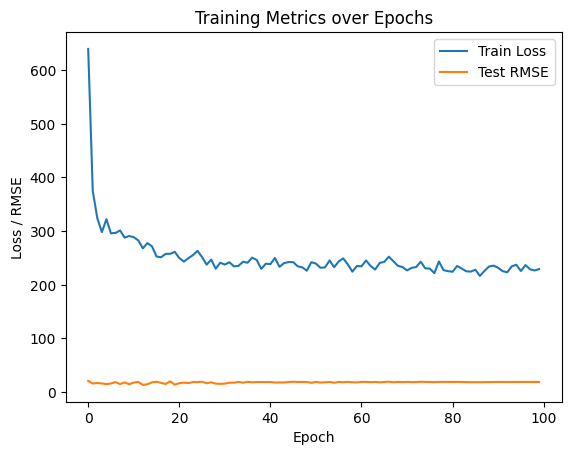

In [21]:
# Working with Linear Features First
# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [128, 64, 32]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss()  # or nn.SmoothL1Loss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=100, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)

        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=5
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 4811.2204 | Test RMSE: 67.0377 | R²: -31.5695
Epoch 11/100 | Train Loss: 243.2496 | Test RMSE: 10.6877 | R²: 0.1722
Epoch 21/100 | Train Loss: 221.0772 | Test RMSE: 9.8616 | R²: 0.2952
Epoch 31/100 | Train Loss: 211.2176 | Test RMSE: 9.6478 | R²: 0.3254
Epoch 41/100 | Train Loss: 214.0421 | Test RMSE: 9.5626 | R²: 0.3373
Epoch 51/100 | Train Loss: 210.9712 | Test RMSE: 9.6349 | R²: 0.3272
Epoch 61/100 | Train Loss: 217.6248 | Test RMSE: 9.5392 | R²: 0.3405
Epoch 71/100 | Train Loss: 211.8004 | Test RMSE: 9.5791 | R²: 0.3350
Epoch 81/100 | Train Loss: 209.1339 | Test RMSE: 9.5516 | R²: 0.3388
Epoch 91/100 | Train Loss: 212.6501 | Test RMSE: 9.5334 | R²: 0.3413


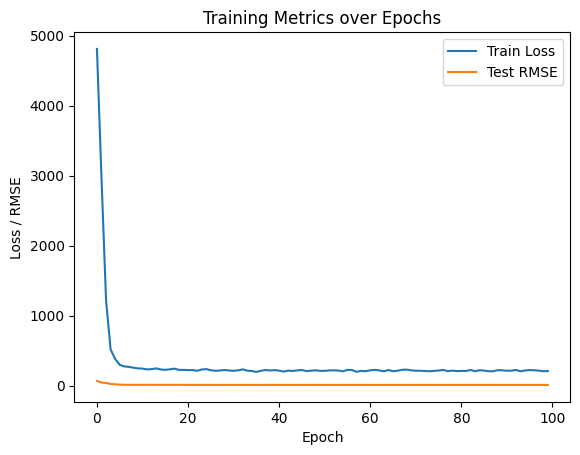

In [22]:
# I know some of the data has outliers want to try scaling and see if it cleans this up any
# Working with Linear Features First
#Apply StandardScaler
scaler = StandardScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss()  # or nn.SmoothL1Loss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=100, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)

        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [128, 64, 32]
dropout_rate = 0.2

model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.GELU, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=10
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 19.1480 | Test RMSE: 20.5800 | R²: -2.0695
Epoch 11/100 | Train Loss: 12.9429 | Test RMSE: 13.5965 | R²: -0.3398
Epoch 21/100 | Train Loss: 12.4213 | Test RMSE: 13.1553 | R²: -0.2542
Epoch 31/100 | Train Loss: 11.9388 | Test RMSE: 15.5669 | R²: -0.7562
Epoch 41/100 | Train Loss: 11.7818 | Test RMSE: 13.8973 | R²: -0.3997
Epoch 51/100 | Train Loss: 11.8943 | Test RMSE: 15.0992 | R²: -0.6523
Epoch 61/100 | Train Loss: 11.8374 | Test RMSE: 15.1700 | R²: -0.6678
Epoch 71/100 | Train Loss: 11.8271 | Test RMSE: 15.2120 | R²: -0.6770
Epoch 81/100 | Train Loss: 11.3557 | Test RMSE: 15.0410 | R²: -0.6396
Epoch 91/100 | Train Loss: 11.4572 | Test RMSE: 15.1471 | R²: -0.6628


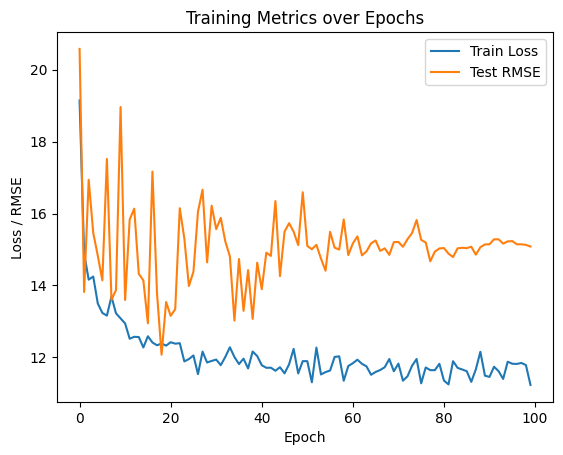

In [23]:
# Going to change from MSELoss to SmoothL1Loss as from my reading it should better handle outliers.  
# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds.values, dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.SmoothL1Loss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)

        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [128, 64, 32]
dropout_rate = 0.2

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=10
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 0.4563 | Test RMSE: 0.6489 | R²: 0.1180
Epoch 11/100 | Train Loss: 0.3597 | Test RMSE: 0.5542 | R²: 0.3567
Epoch 21/100 | Train Loss: 0.3549 | Test RMSE: 0.5516 | R²: 0.3628
Epoch 31/100 | Train Loss: 0.3464 | Test RMSE: 0.5494 | R²: 0.3679
Epoch 41/100 | Train Loss: 0.3390 | Test RMSE: 0.5532 | R²: 0.3590
Epoch 51/100 | Train Loss: 0.3417 | Test RMSE: 0.5524 | R²: 0.3608
Epoch 61/100 | Train Loss: 0.3368 | Test RMSE: 0.5527 | R²: 0.3603
Epoch 71/100 | Train Loss: 0.3346 | Test RMSE: 0.5523 | R²: 0.3612
Epoch 81/100 | Train Loss: 0.3393 | Test RMSE: 0.5523 | R²: 0.3612
Epoch 91/100 | Train Loss: 0.3405 | Test RMSE: 0.5525 | R²: 0.3606


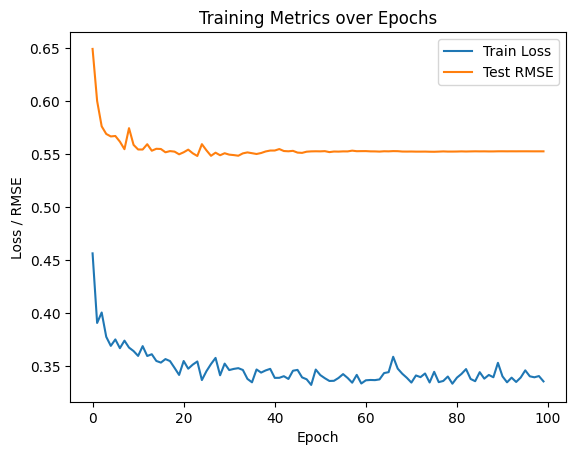

In [24]:
# Going back to MSELoss from SmoothL1Loss , next going to scale the data using either Standard or Robust Scaler - Will keep the one that performs better
    # SS - Epoch 91/100 | Train Loss: 0.7517 | Test RMSE: 0.8285 | R²: 0.3118
    # RBS - Epoch 91/100 | Train Loss: 0.3411 | Test RMSE: 0.5855 | R²: 0.3202
    # Going to stick with RBS

#Apply StandardScaler or RobustScaler
scaler = RobustScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)
y_train_linear_feature_importance_ds_scaled = scaler.fit_transform(y_train_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_linear_feature_importance_ds_scaled = scaler.transform(y_test_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss()  

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)

        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [128, 64, 32]
dropout_rate = 0.2

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=10
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 0.2278 | Test RMSE: 0.6766 | R²: 0.0412
Epoch 11/100 | Train Loss: 0.1785 | Test RMSE: 0.5633 | R²: 0.3354
Epoch 21/100 | Train Loss: 0.1733 | Test RMSE: 0.5540 | R²: 0.3572
Epoch 31/100 | Train Loss: 0.1753 | Test RMSE: 0.5513 | R²: 0.3633
Epoch 41/100 | Train Loss: 0.1691 | Test RMSE: 0.5504 | R²: 0.3654
Epoch 51/100 | Train Loss: 0.1685 | Test RMSE: 0.5516 | R²: 0.3627
Epoch 61/100 | Train Loss: 0.1716 | Test RMSE: 0.5522 | R²: 0.3614
Epoch 71/100 | Train Loss: 0.1681 | Test RMSE: 0.5528 | R²: 0.3600
Epoch 81/100 | Train Loss: 0.1661 | Test RMSE: 0.5525 | R²: 0.3607
Epoch 91/100 | Train Loss: 0.1715 | Test RMSE: 0.5523 | R²: 0.3610


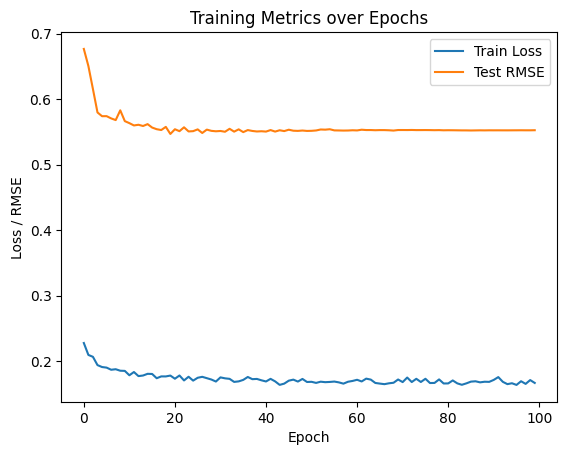

Model saved to: C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\NN_linfea_data.pth


In [25]:
# Building on the last model, to combat overfitting adding a layer and adjusting some of the layers
    # Started at - poch 91/100 | Train Loss: 0.3353 | Test RMSE: 0.5816 | R²: 0.3291
    # layers [128, 64, 32, 8] - Epoch 91/100 | Train Loss: 0.1725 | Test RMSE: 0.5870 | R²: 0.3168
    # layers [256, 64, 32, 8] - Epoch 91/100 | Train Loss: 0.1712 | Test RMSE: 0.5762 | R²: 0.3416
    # layers [256, 128, 64, 32, 16, 8] - Epoch 91/100 | Train Loss: 0.1718 | Test RMSE: 0.5861 | R²: 0.3188
    # layers [256, 64, 8, 4] - Epoch 91/100 | Train Loss: 0.1899 | Test RMSE: 0.6427 | R²: 0.1809
    # layers [256, 64, 16, 4] - poch 91/100 | Train Loss: 0.1852 | Test RMSE: 0.5829 | R²: 0.3262
    # layers [256, 64, 16, 8] - Epoch 91/100 | Train Loss: 0.1717 | Test RMSE: 0.5806 | R²: 0.3314
    # layers [256, 128, 32, 8, 4] - Epoch 91/100 | Train Loss: 0.1837 | Test RMSE: 0.5973 | R²: 0.2925
    # layers [256, 64, 32, 8, 4] - Epoch 91/100 | Train Loss: 0.1797 | Test RMSE: 0.5810 | R²: 0.3306
# Going to stick with 
scaler = RobustScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)
y_train_linear_feature_importance_ds_scaled = scaler.fit_transform(y_train_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_linear_feature_importance_ds_scaled = scaler.transform(y_test_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device) # Save this model with Pickle

# Loss function options
criterion = nn.SmoothL1Loss()  # or nn.MSELoss()

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)

        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=10
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()
# Save the model for bracket simulation
model_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\NN_linfea_data.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Epoch 1/100 | Train Loss: 0.6133 | Test RMSE: 0.9004 | R²: -0.6981
Epoch 100/100 | Train Loss: 0.3808 | Test RMSE: 0.5630 | R²: 0.3360


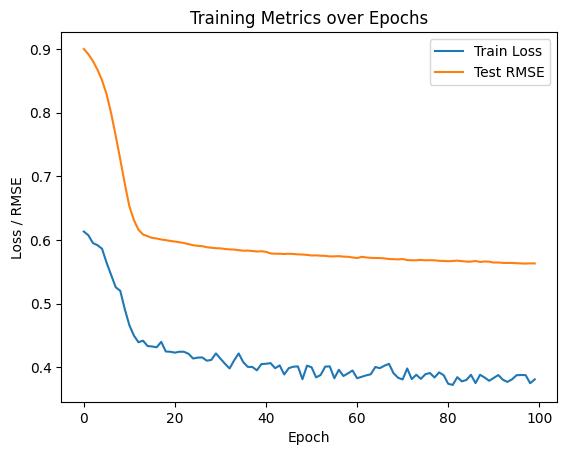

In [26]:
# Next Step adjust the learning rate.  Will try 
    # CosineAnnealingWarRestarts - Epoch 91/100 | Train Loss: 0.1571 | Test RMSE: 0.6047 | R²: 0.2748
    # ReduceLROnPlateau - Epoch 91/100 | Train Loss: 0.1729 | Test RMSE: 0.6115 | R²: 0.2584
    # OneCycleLR - Epoch 91/100 | Train Loss: 0.3777 | Test RMSE: 0.5795 | R²: 0.3341
    # Started - Epoch 91/100 | Train Loss: 0.1683 | Test RMSE: 0.5833 | R²: 0.3253
# Going to stick with OneCycleLR

scaler = RobustScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)
y_train_linear_feature_importance_ds_scaled = scaler.fit_transform(y_train_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_linear_feature_importance_ds_scaled = scaler.transform(y_test_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3,
                                                anneal_strategy='cos', final_div_factor=1e4)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 0.5508 | Test RMSE: 0.6888 | R²: 0.0062
Epoch 100/100 | Train Loss: 0.3818 | Test RMSE: 0.5676 | R²: 0.3252


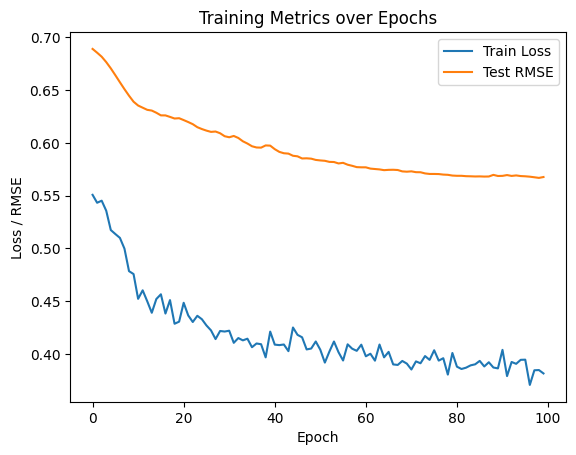

In [27]:
# In previous played with hidden layers and settled on [256, 64, 16, 4] from [128, 64, 32, 8]
# Going to attempt to look at different optimizers (AdamW, RMSprop, NAdam, SGD) - Will try each one at a time and attach the final output line to each
    # Started - Epoch 91/100 | Train Loss: 0.3777 | Test RMSE: 0.5795 | R²: 0.3341
    # AdamW - Epoch 91/100 | Train Loss: 0.3900 | Test RMSE: 0.5895 | R²: 0.3108 and Epoch 91/100 | Train Loss: 0.3855 | Test RMSE: 0.5936 | R²: 0.3012
    # RMSprop - Epoch 91/100 | Train Loss: 0.2807 | Test RMSE: 0.5971 | R²: 0.2930
    # NAdam - Epoch 91/100 | Train Loss: 0.3867 | Test RMSE: 0.5880 | R²: 0.3144 and Epoch 91/100 | Train Loss: 0.3737 | Test RMSE: 0.5844 | R²: 0.3228
    # SGD - Epoch 91/100 | Train Loss: 0.4862 | Test RMSE: 0.7342 | R²: -0.0689
    # Adam - Epoch 91/100 | Train Loss: 0.4019 | Test RMSE: 0.5934 | R²: 0.3018 and Epoch 91/100 | Train Loss: 0.3858 | Test RMSE: 0.5948 | R²: 0.2983
# Will stick with - NAdam


scaler = RobustScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)
y_train_linear_feature_importance_ds_scaled = scaler.fit_transform(y_train_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_linear_feature_importance_ds_scaled = scaler.transform(y_test_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3,
                                                anneal_strategy='cos', final_div_factor=1e4)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 0.5208 | Test RMSE: 0.7727 | R²: -0.2504
Epoch 100/100 | Train Loss: 0.3393 | Test RMSE: 0.5743 | R²: 0.3092


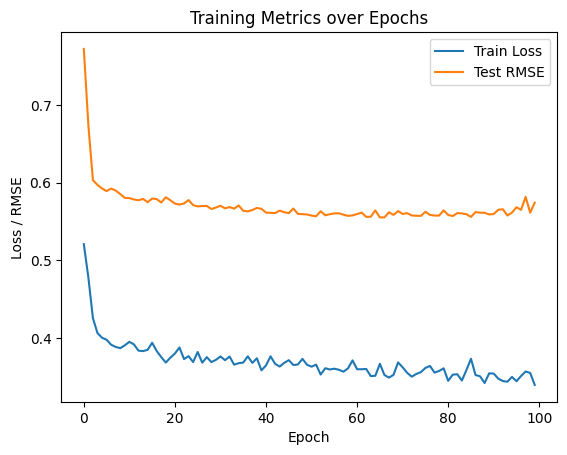

In [28]:
'''
Tweak HyperParameters on scheduler
    1) scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.1, 
    anneal_strategy='linear', three_phase=True) - Epoch 91/100 | Train Loss: 0.3626 | Test RMSE: 0.5911 | R²: 0.3070
    2) scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3,
    div_factor=10, final_div_factor=1e4, anneal_strategy='cos') - Epoch 91/100 | Train Loss: 0.3457 | Test RMSE: 0.5816 | R²: 0.3292
'''
scaler = RobustScaler()

# Fit only on training set
x_train_linear_feature_importance_ds_scaled = scaler.fit_transform(x_train_linear_feature_importance_ds.values)
x_test_linear_feature_importance_ds_scaled = scaler.transform(x_test_linear_feature_importance_ds.values)
y_train_linear_feature_importance_ds_scaled = scaler.fit_transform(y_train_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_linear_feature_importance_ds_scaled = scaler.transform(y_test_linear_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_linear_feature_importance_ds_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_linear_feature_importance_ds_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=2e-3, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs=100, 
                                                pct_start=0.3,       
                                                anneal_strategy='cos', 
                                                div_factor=10)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Think have found the best set of parameters for the neural network.  It still isn't where I want it to be, but its better.  Next lets try this model on all the factors and on by round analysis sets. 

Epoch 1/100 | Train Loss: 0.5575 | Test RMSE: 0.6899 | R²: 0.0030
Epoch 100/100 | Train Loss: 0.3121 | Test RMSE: 0.5623 | R²: 0.3377


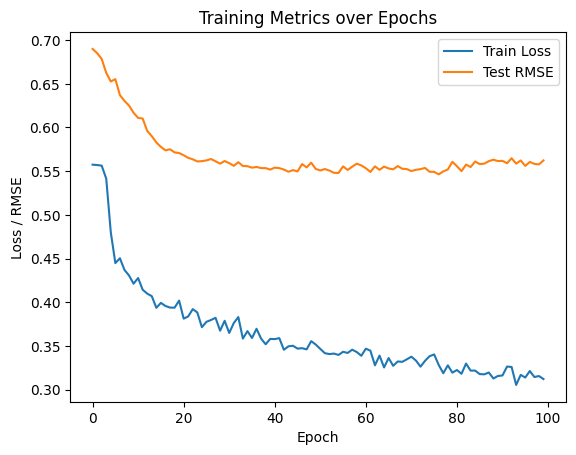

In [29]:
# Round Analysis Set of Data
scaler = RobustScaler()

# Fit only on training set
x_train_scaled = scaler.fit_transform(x_train_round_tend_analysis_features_ds.values)
x_test_scaled = scaler.transform(x_test_round_tend_analysis_features_ds.values)
y_train_scaled = scaler.fit_transform(y_train_round_tend_analysis_features_ds.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test_round_tend_analysis_features_ds .values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3, 
                                                anneal_strategy='cos', div_factor=10)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

Epoch 1/100 | Train Loss: 0.5537 | Test RMSE: 0.7563 | R²: -0.1980
Epoch 100/100 | Train Loss: 0.2465 | Test RMSE: 0.6034 | R²: 0.2373


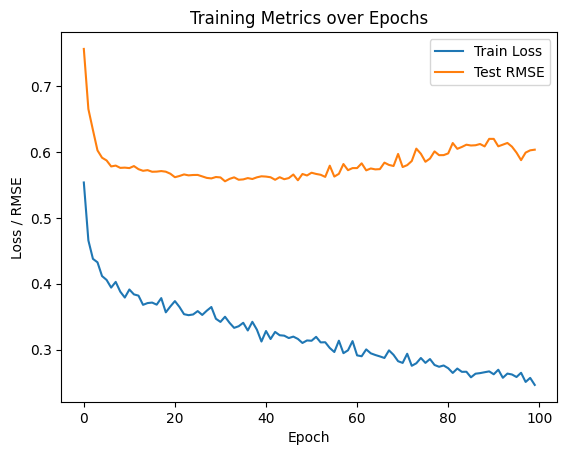

In [30]:
# Full Bracket Set of Data
scaler = RobustScaler()

# Fit only on training set
x_train_scaled = scaler.fit_transform(x_train_bracket_data_set.values)
x_test_scaled = scaler.transform(x_test_bracket_data_set.values)
y_train_scaled = scaler.fit_transform(y_train_bracket_data_set.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test_bracket_data_set.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3, 
                                                anneal_strategy='cos', div_factor=10)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

In [31]:
def gradient_sensitivity(model, x_data_tensor, y_data_tensor, feature_names, device='cuda'):
    model.eval()
    sensitivities = []

    x_data_tensor = x_data_tensor.clone().detach().requires_grad_(True).to(device)
    y_data_tensor = y_data_tensor.to(device)

    model.zero_grad()
    outputs = model(x_data_tensor).squeeze()
    loss = nn.MSELoss()(outputs, y_data_tensor)
    loss.backward()

    grads = x_data_tensor.grad.detach().cpu().numpy()
    mean_abs_grads = np.mean(np.abs(grads), axis=0)

    for name, grad_val in zip(feature_names, mean_abs_grads):
        sensitivities.append((name, grad_val))

    return sorted(sensitivities, key=lambda x: x[1], reverse=True)

feature_names = x_train_bracket_data_set.columns.tolist()
gradient_scores = gradient_sensitivity(model, x_test_tensor, y_test_tensor, feature_names)

perm_df = importance_scores.reset_index()
perm_df.columns = ['Feature', 'Delta_RMSE']
grad_df = pd.DataFrame(gradient_scores, columns=['Feature', 'Gradient_Sensitivity'])
combined_df = pd.merge(perm_df, grad_df, on='Feature')
combined_df.sort_values(by='Delta_RMSE', ascending=False, inplace=True)
combined_df.to_csv('Neural_Network_combined_feature_importance.csv', index=False)


In [32]:
#output_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Model Creation Data\Neural_Network_combined_feature_importance.csv"
output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Model Creation Data\Neural_Network_combined_feature_importance.csv"
combined_df.to_csv(output_path, index=False)

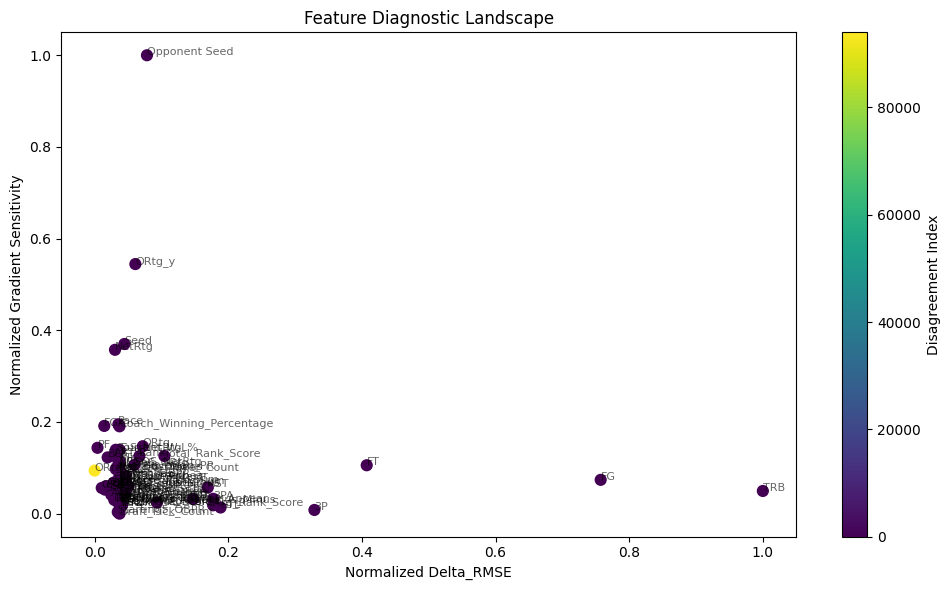

In [33]:
# take a deeper look at the features 
columns_to_normailize = ['Delta_RMSE', 'Gradient_Sensitivity']
scaler = MinMaxScaler()
NN_CFI_Deeper = combined_df.copy()
NN_CFI_Deeper[[f"{col}_Norm" for col in columns_to_normailize]] = scaler.fit_transform(combined_df[columns_to_normailize])
NN_CFI_Deeper['Disagreement_Index'] = NN_CFI_Deeper["Gradient_Sensitivity_Norm"] / (NN_CFI_Deeper["Delta_RMSE_Norm"] + 1e-6)

plt.figure(figsize=(10, 6))
plt.scatter(NN_CFI_Deeper["Delta_RMSE_Norm"], NN_CFI_Deeper["Gradient_Sensitivity_Norm"], c=NN_CFI_Deeper["Disagreement_Index"], cmap="viridis", s=60)
plt.colorbar(label="Disagreement Index")
plt.xlabel("Normalized Delta_RMSE")
plt.ylabel("Normalized Gradient Sensitivity")
plt.title("Feature Diagnostic Landscape")
for i, txt in enumerate(NN_CFI_Deeper["Feature"]):
    plt.annotate(txt, (NN_CFI_Deeper["Delta_RMSE_Norm"].iloc[i], NN_CFI_Deeper["Gradient_Sensitivity_Norm"].iloc[i]), fontsize=8, alpha=0.6)
plt.tight_layout()
plt.show()

In [34]:
NN_CFI_Deeper

,Feature,Delta_RMSE,Gradient_Sensitivity,Delta_RMSE_Norm,Gradient_Sensitivity_Norm,Disagreement_Index
15,TRB,254.380325,0.000303,1.000000,0.049489,0.049489
5,FG,190.253450,0.000365,0.757309,0.073793,0.097441
11,FT,97.724341,0.000446,0.407127,0.105612,0.259406
8,3P,77.045610,0.000198,0.328868,0.008064,0.024521
17,STL,39.912765,0.000212,0.188337,0.013396,0.071127
...,...,...,...,...,...,...
51,SoS_DRtg,-5.754903,0.000311,0.015505,0.052334,3.375114
6,FGA,-6.065424,0.000665,0.014330,0.191404,13.356215
14,ORB,-7.066837,0.000320,0.010540,0.056151,5.327058
20,PF,-8.736812,0.000543,0.004220,0.143640,34.032324


# Of the Neural Networks - tested 3 data sets
Full Data Set - Epoch 901/1000 | Train Loss: 0.0713 | Test RMSE: 0.5933 | R²: 0.3019
Round Analysis Data Set - Epoch 901/1000 | Train Loss: 0.1384 | Test RMSE: 0.6205 | R²: 0.2365
Linear Regression Data Set - Epoch 91/100 | Train Loss: 0.3457 | Test RMSE: 0.5816 | R²: 0.3292
## When running feature Importance against the full Data Set
##### It was found that: The model reacts sharply to Opponent Score, Opponent Seed, Current Round, NetRtg
##### It was also found that the main supporting features were Avg_Rank_Score, Bench_Plus_Minus, Total_Rank_Score, TRB, FG, FGA, Starting5_Plus_Minus, Avg_Plus_Minus, and ORB.  

In [35]:
# Create Data Set from Neural Network Features
NN_fea_columns = ['Year', 'Score', 'Team', 'Opponent Seed', 'NetRtg', 'Avg_Rank_Score', 'Bench_Plus_Minus', 'Total_Rank_Score', 'TRB',
                  'FG', 'FGA', 'Starting5_Plus_Minus', 'Avg_Plus_Minus', 'ORB']
# 'Opponent_Score' has to be left out due to not being able to know ahead of the game.
NN_feature_importance_ds = bracket_data_set[NN_fea_columns]

# Create Test and Train Sets
test_NN_feature_importance_ds = NN_feature_importance_ds[(NN_feature_importance_ds["Year"] == 2025)]
train_NN_feature_importance_ds = NN_feature_importance_ds[(NN_feature_importance_ds["Year"] < 2025)]

# X and Y / Test and Train
NN_dropped_columns_train = train_NN_feature_importance_ds[['Year', 'Score', 'Team']]
NN_dropped_columns_test = test_NN_feature_importance_ds[['Year', 'Score', 'Team']]
x_train_NN_feature_importance_ds = train_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_NN_feature_importance_ds = train_NN_feature_importance_ds['Score']
x_test_NN_feature_importance_ds = test_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_NN_feature_importance_ds = test_NN_feature_importance_ds['Score']

Epoch 1/100 | Train Loss: 0.5157 | Test RMSE: 0.6820 | R²: 0.0258
Epoch 100/100 | Train Loss: 0.3531 | Test RMSE: 0.5765 | R²: 0.3039


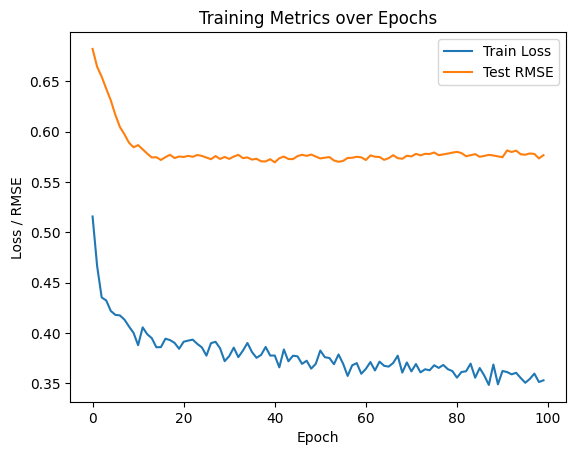

In [36]:
# Round Analysis Set of Data
scaler = RobustScaler()

# Fit only on training set
x_train_scaled = scaler.fit_transform(x_train_NN_feature_importance_ds.values)
x_test_scaled = scaler.transform(x_test_NN_feature_importance_ds.values)
y_train_scaled = scaler.fit_transform(y_train_NN_feature_importance_ds.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test_NN_feature_importance_ds.values.reshape(-1, 1)).flatten()

# Convert to Tensor
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled , dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled , dtype=torch.float32).to(device)

# Wrap it with DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Start building the network
class MarMad_Neural_Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(activation_fn()) # Allows for changing of activation function
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get model basics setup and ready
input_dim = x_train_tensor.shape[1]
output_dim = 1
hidden_dims = [256, 64, 32, 8]
dropout_rate = 0.2

# Swap ReLU, ELU, SiLU, other
model = MarMad_Neural_Net(input_dim, hidden_dims, output_dim, activation_fn=nn.ReLU, dropout=dropout_rate).to(device)

# Loss function options
criterion = nn.MSELoss() 

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)

# Scheduler to decay LR over time
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3, steps_per_epoch=len(train_loader), epochs=100, pct_start=0.3, 
                                                anneal_strategy='cos', div_factor=10)

def train_nn_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs=50, device='cuda', use_clip=True,
    clip_value=1.0, log_every=1):

    model.train()
    train_loss_history = []
    test_rmse_history = []
    test_r2_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if use_clip:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = []
            true = []
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds.extend(outputs.squeeze().cpu().numpy())
                true.extend(targets.cpu().numpy())  
                
        rmse = np.sqrt(mean_squared_error(true, preds))
        r2 = r2_score(true, preds)
        test_rmse_history.append(rmse)
        test_r2_history.append(r2)
        scheduler.step()                
        if epoch % log_every == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test RMSE: {rmse:.4f} | R²: {r2:.4f}")

        model.train()

    return {
        "train_loss": train_loss_history,
        "test_rmse": test_rmse_history,
        "test_r2": test_r2_history
    }

# Training Loop
metrics = train_nn_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=100,  
    device=device,
    log_every=99
)

plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_rmse"], label="Test RMSE")
plt.legend()
plt.title("Training Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.show()

# Random Forest Models
For this I am going to start with the larger data set and try to get the parameters on point then apply them to the other sets of data.  
###### Linear Regression Parameters
###### Round Analysis Parameters
###### Neural Network Parameters
###### Random Forest Permutation Parameters

In [37]:
print(bracket_data_set.head(15))
print()
print()
print('COLUMNS')
print(bracket_data_set.columns)
print()
print()
print('SHAPE')
print(bracket_data_set.shape)
print()
print()
print('INFO')
print(bracket_data_set.info())
print()
print()
print('DESCRIBE')
print(bracket_data_set.describe())
print()
print()
print('SUM NA')
print(bracket_data_set.isna().sum().sort_values(ascending=False))
print()
print()
print('SUM DUPLICATED')
print(bracket_data_set.duplicated().sum())

    Year              Team  Seed  Score  Opponent Seed  Result  Champion  \
0   2024       Connecticut     1     91             16       1         0   
1   2024           Stetson    16     52              1       0         0   
2   2024  Florida Atlantic     8     65              9       0         0   
3   2024      Northwestern     9     77              8       1         0   
4   2024   San Diego State     5     69             12       1         0   
5   2024               UAB    12     65              5       0         0   
6   2024            Auburn     4     76             13       0         0   
7   2024              Yale    13     78              4       1         0   
8   2024               BYU     6     67             11       0         0   
9   2024          Duquesne    11     71              6       1         0   
10  2024          Illinois     3     85             14       1         0   
11  2024    Morehead State    14     69              3       0         0   
12  2024  Wa

In [38]:
x_train_bracket_data_set = train_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion'])
y_train_bracket_data_set = train_bracket_data_set['Score']
x_test_bracket_data_set = test_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion'])
y_test_bracket_data_set = test_bracket_data_set['Score']

scaler = StandardScaler()

x_train_bracket_data_set_scaled = scaler.fit_transform(x_train_bracket_data_set.values)
y_train_bracket_data_set_scaled = scaler.fit_transform(y_train_bracket_data_set.values.reshape(-1, 1))
x_test_bracket_data_set_scaled = scaler.fit_transform(x_test_bracket_data_set.values)
y_test_bracket_data_set_scaled  = scaler.fit_transform(y_test_bracket_data_set.values.reshape(-1, 1))

# Going to start with the unscaled data from the bracket_data_set
X_train = x_train_bracket_data_set
X_test = x_test_bracket_data_set
y_train = y_train_bracket_data_set
y_test = y_test_bracket_data_set
# 78 features - Change this data set name so know its the right one for Web App training
output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\Test Sets from time of model trainings\x_test_bracket_data_set.csv"
x_test_bracket_data_set.to_csv(output_path, index=False)

# Define the Random Forest with base settings
rf = RandomForestRegressor(  
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.9,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
    'min_samples_split': [3],
    'max_features': [0.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
rf_bracket_data = grid_search.best_estimator_ # Model to save out with pickle
# Ensure the folder exists
os.makedirs("models", exist_ok=True)

# Save the model
#model_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\rf_bracket_data.pkl"
#with open(model_path, "wb") as f:
#    pickle.dump(rf_bracket_data, f)

# Generate predictions
y_pred = rf_bracket_data.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best Model Parameters", rf_bracket_data)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Prediction preview:", y_pred[:5])
print("Best CV score (R² by default):", grid_search.best_score_)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.head())

# First interation found that Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
#Mean Squared Error: 87.89646694853336
#R-squared: 0.3968454220302946
# param_grid = {
#    'n_estimators': [100, 250, 500],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'max_features': ['sqrt', 'log2']

# Second Interation found that Best parameters: {'max_depth': 30, 'max_features': 25, 'min_samples_split': 3, 'n_estimators': 500}
#Mean Squared Error: 82.31208452658646
#R-squared: 0.4351660273955029
#param_grid = {
#    'n_estimators': [500, 600, 750, 1000],
#    'max_depth': [15, 20, 25, 30],
#    'min_samples_split': [2, 3, 4],
#    'max_features': ['sqrt', 5, 10, 15, 20, 25]

# third Interation found that Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
#Mean Squared Error: 77.02347153730695
#R-squared: 0.471457032555719
#param_grid = {
#    'n_estimators': [500],
#   'max_depth': [23, 24, 25, 26, 27],
#    'min_samples_split': [3],
#    'max_features': [.1, .3, .5, .7, .9, 25]

# Model r-squared dropped after removal of Opponent Score was taken out.  still a better indicator than the Neural Network at this point.

# New scores after dropping Opponent Score
#Mean Squared Error: 89.61397844697511
#R-squared: 0.3850596818411317

# fourth Interation was the addition of Standard or Robust Scaler
# Standard Scaler Scores to x and y variables
#Mean Squared Error: 0.6558852285266578
#R-squared: 0.34411477147334235

# Robust Scaler Scores to x and y variables
#Mean Squared Error: 0.3605319126328733
#R-squared: 0.2850119799501174

# Standard Scaler Scores to x variables
#Mean Squared Error: 113.22832564579862
#R-squared: 0.22301560756592387

# Robust Scaler Scores to x variables
#Mean Squared Error: 139.85959900417947
#R-squared: 0.040269076323941055

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
Best Model Parameters RandomForestRegressor(max_depth=25, max_features=0.9, min_samples_split=3,
                      n_estimators=500, n_jobs=-1, random_state=42)
Mean Squared Error: 84.57901048144484
R-squared: 0.38703638782903393
Prediction preview: [67.88767381 63.64966349 79.1473381  67.37709286 61.00241905]
Best CV score (R² by default): 0.1860008794738222
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.15284      0.047827         0.097826        0.020479   

  param_max_depth param_max_features param_min_samples_split  \
0              25                0.9                       3   

  param_n_estimators                                             params  \
0                500  {'max_depth': 25, 'max_features': 0.9, 'min_sa...   

   split0_test_score  split1_test_score  split2_test_score 

In [39]:
# Save the model
model_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\rf_bracket_data.pkl"
with open(model_path, "wb") as f:
    pickle.dump(rf_bracket_data, f)

                 Feature  Mean Importance  Std Dev
           Opponent Seed           0.1494   0.0375
                  ORtg_y           0.0892   0.0289
                      FG           0.0692   0.0209
                     FT%           0.0111   0.0039
                    Pace           0.0089   0.0057
              SoS_NetRtg           0.0076   0.0052
                    AdjT           0.0069   0.0036
                Combined           0.0051   0.0054
                SoS_ORtg           0.0041   0.0040
                     FGA           0.0038   0.0071
              Pass_Score           0.0033   0.0018
                  ORtg_x           0.0031   0.0028
                     3PA           0.0030   0.0017
                      PF           0.0028   0.0025
                  FT/FGA           0.0027   0.0011
          Teamwork_Index           0.0025   0.0016
                     FTr           0.0024   0.0022
          Starting5_OBPR           0.0024   0.0026
                    3PAr       

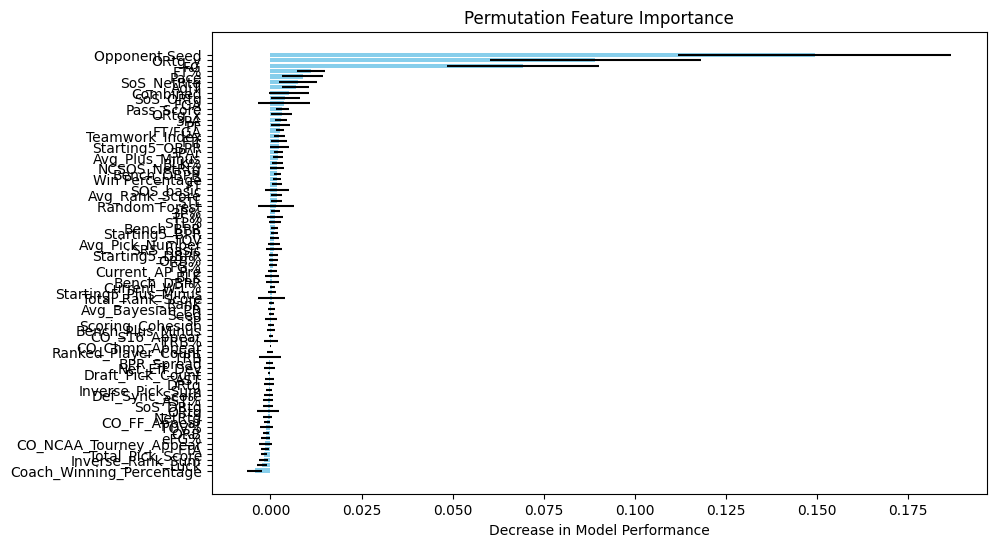

In [40]:
feature_names = x_test_bracket_data_set.columns

# Run permutation importance on the test set
result = permutation_importance(
    rf_bracket_data, X_test, y_test,
    n_repeats = 100,
    random_state = 42,
    n_jobs = -1
)

# Sort and print results
sorted_idx = np.argsort(result.importances_mean)[::-1]
importance_df = pd.DataFrame({
    "Feature": [feature_names[i] for i in sorted_idx],
    "Mean Importance": result.importances_mean[sorted_idx],
    "Std Dev": result.importances_std[sorted_idx]
})

importance_df = importance_df.round(4)

print(importance_df.to_string(index=False))


plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx],
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    color='skyblue'
)
plt.gca().invert_yaxis()
plt.xlabel("Decrease in Model Performance")
plt.title("Permutation Feature Importance")
plt.show()

In [41]:
# Going to work with the RF Features only and see how that comes out
'''
Create a Random Forest Data Set with the cutoff bing at +/- .003.  This will give us Luck, ORtg_y, FG, Current Round, Opponent Seed, SoS_NetRtg, Pace,
FT%, FGA, SoS_ORtg, TOV, AdjT, TRB, 3PA, BLK, ORtg_x, SOS_basic.
'''
RF_features = ['Luck', 'ORtg_y', 'FG', 'Current Round', 'Opponent Seed', 'SoS_NetRtg', 'Pace', 'FT%', 'FGA', 'SoS_ORtg', 'TOV', 'AdjT', 'TRB', '3PA', 
               'BLK', 'ORtg_x', 'SOS_basic', 'Year', 'Score', 'Team']

RF_features_ds = bracket_data_set[round_tend_analysis_features]

# Create Test and Train Sets
test_RF_features_ds = RF_features_ds[(RF_features_ds["Year"] == 2025)]
train_RF_features_ds = RF_features_ds[(RF_features_ds["Year"] < 2025)]

# X and Y / Test and Train
dropped_columns_train = test_RF_features_ds[['Year', 'Score', 'Team']]
dropped_columns_test = test_RF_features_ds[['Year', 'Score', 'Team']]
x_train_RF_features_ds = train_RF_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_RF_features_ds = train_RF_features_ds['Score']
x_test_RF_features_ds = test_RF_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_RF_features_ds = test_RF_features_ds['Score']

X_train = x_train_RF_features_ds
X_test = x_test_RF_features_ds
y_train = y_train_RF_features_ds
y_test = y_test_RF_features_ds
# 17 features


# Define the Random Forest with base settings
rf = RandomForestRegressor(  
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.9,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
    'min_samples_split': [3],
    'max_features': [.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
NN_best_rf = grid_search.best_estimator_

# Generate predictions
y_pred = NN_best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best Model Parameters", NN_best_rf)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Prediction preview:", y_pred[:5])
print("Best CV score (R² by default):", grid_search.best_score_)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.head())

#Mean Squared Error: 91.01865609052255
#R-squared: 0.37542063967378925

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
Best Model Parameters RandomForestRegressor(max_depth=25, max_features=0.9, min_samples_split=3,
                      n_estimators=500, n_jobs=-1, random_state=42)
Mean Squared Error: 86.34372917173361
R-squared: 0.3742470641338562
Prediction preview: [69.96217143 64.76545238 77.69838398 66.40404992 62.16084286]
Best CV score (R² by default): 0.1728662502643544
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.487202      0.034601         0.084817        0.035042   

  param_max_depth param_max_features param_min_samples_split  \
0              25                0.9                       3   

  param_n_estimators                                             params  \
0                500  {'max_depth': 25, 'max_features': 0.9, 'min_sa...   

   split0_test_score  split1_test_score  split2_test_score  

In [42]:
# Going to work the Neural Network Features next and see how that comes out
x_train_NN_feature_importance_ds = train_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_NN_feature_importance_ds = train_NN_feature_importance_ds['Score']
x_test_NN_feature_importance_ds = test_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_NN_feature_importance_ds = test_NN_feature_importance_ds['Score']

X_train = x_train_NN_feature_importance_ds
X_test = x_test_NN_feature_importance_ds
y_train = y_train_NN_feature_importance_ds
y_test = y_test_NN_feature_importance_ds
# 12 features


# Define the Random Forest with base settings
rf = RandomForestRegressor(  
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.9,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
    'min_samples_split': [3],
    'max_features': [.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
NN_best_rf = grid_search.best_estimator_

# Generate predictions
y_pred = NN_best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best Model Parameters", NN_best_rf)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Prediction preview:", y_pred[:5])
print("Best CV score (R² by default):", grid_search.best_score_)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.head())

# First Run resulted in 
#Mean Squared Error: 97.10402570011728
#R-squared: 0.33366220880518627

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
Best Model Parameters RandomForestRegressor(max_depth=25, max_features=0.9, min_samples_split=3,
                      n_estimators=500, n_jobs=-1, random_state=42)
Mean Squared Error: 99.72218703283397
R-squared: 0.2772902918905089
Prediction preview: [71.46325714 64.99192857 74.24333333 61.24346022 62.27641905]
Best CV score (R² by default): 0.11623089594002863
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.728034      0.018965         0.071196        0.007187   

  param_max_depth param_max_features param_min_samples_split  \
0              25                0.9                       3   

  param_n_estimators                                             params  \
0                500  {'max_depth': 25, 'max_features': 0.9, 'min_sa...   

   split0_test_score  split1_test_score  split2_test_score 

In [43]:
# Going to work the Linear Features next and see how that comes out
x_train_linear_feature_importance_ds = train_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_linear_feature_importance_ds = train_linear_feature_importance_ds['Score']
x_test_linear_feature_importance_ds = test_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_linear_feature_importance_ds = test_linear_feature_importance_ds['Score']

X_train = x_train_linear_feature_importance_ds
X_test = x_test_linear_feature_importance_ds
y_train = y_train_linear_feature_importance_ds
y_test = y_test_linear_feature_importance_ds
# 15 features


# Define the Random Forest with base settings
rf = RandomForestRegressor(  
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.9,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
    'min_samples_split': [3],
    'max_features': [.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
linear_best_rf = grid_search.best_estimator_

# Generate predictions
y_pred = linear_best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best Model Parameters", linear_best_rf)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Prediction preview:", y_pred[:5])
print("Best CV score (R² by default):", grid_search.best_score_)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.head())

#Resulted in 
#Mean Squared Error: 90.29155111280296
#R-squared: 0.38041010866158054

#model_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\rf_linfea_data.pkl"
#with open(model_path, "wb") as f: pickle.dump(linear_best_rf, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
Best Model Parameters RandomForestRegressor(max_depth=25, max_features=0.9, min_samples_split=3,
                      n_estimators=500, n_jobs=-1, random_state=42)
Mean Squared Error: 86.49276450239476
R-squared: 0.37316697069101323
Prediction preview: [68.72308571 66.01554286 78.3827     66.14344199 58.38660476]
Best CV score (R² by default): 0.1646194120755897
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.873639      0.015697         0.068933        0.002712   

  param_max_depth param_max_features param_min_samples_split  \
0              25                0.9                       3   

  param_n_estimators                                             params  \
0                500  {'max_depth': 25, 'max_features': 0.9, 'min_sa...   

   split0_test_score  split1_test_score  split2_test_score 

In [44]:
# Going to work the Round Analysis Features next and see how that comes out
x_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds['Score']
x_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds['Score']

X_train = x_train_round_tend_analysis_features_ds
X_test = x_test_round_tend_analysis_features_ds
y_train = y_train_round_tend_analysis_features_ds
y_test = y_test_round_tend_analysis_features_ds
# 30 features


# Define the Random Forest with base settings
rf = RandomForestRegressor(  
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.9,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
    'min_samples_split': [3],
    'max_features': [.9]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
RA_best_rf = grid_search.best_estimator_

# Generate predictions
y_pred = RA_best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best Model Parameters", RA_best_rf)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Prediction preview:", y_pred[:5])
print("Best CV score (R² by default):", grid_search.best_score_)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.head())

#model_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\rf_rouanly_data.pkl"
#with open(model_path, "wb") as f: pickle.dump(RA_best_rf, f)
    
# Resulted in 
#Mean Squared Error: 91.01865609052254
#R-squared: 0.37542063967378936

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 25, 'max_features': 0.9, 'min_samples_split': 3, 'n_estimators': 500}
Best Model Parameters RandomForestRegressor(max_depth=25, max_features=0.9, min_samples_split=3,
                      n_estimators=500, n_jobs=-1, random_state=42)
Mean Squared Error: 86.3437291717336
R-squared: 0.37424706413385633
Prediction preview: [69.96217143 64.76545238 77.69838398 66.40404992 62.16084286]
Best CV score (R² by default): 0.17286625026435448
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.465805        0.0663         0.102248        0.046341   

  param_max_depth param_max_features param_min_samples_split  \
0              25                0.9                       3   

  param_n_estimators                                             params  \
0                500  {'max_depth': 25, 'max_features': 0.9, 'min_sa...   

   split0_test_score  split1_test_score  split2_test_score 

# XGBoost

In [45]:
# Going to start with the unscaled data from the bracket_data_set
x_train_bracket_data_set = train_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion'])
y_train_bracket_data_set = train_bracket_data_set['Score']
x_test_bracket_data_set = test_bracket_data_set.drop(columns=['Year', 'Score', 'Team', 'Result', 'Champion'])
y_test_bracket_data_set = test_bracket_data_set['Score']

scaler = StandardScaler()

x_train_bracket_data_set_scaled = scaler.fit_transform(x_train_bracket_data_set.values)
y_train_bracket_data_set_scaled = scaler.fit_transform(y_train_bracket_data_set.values.reshape(-1, 1))
x_test_bracket_data_set_scaled = scaler.fit_transform(x_test_bracket_data_set.values)
y_test_bracket_data_set_scaled  = scaler.fit_transform(y_test_bracket_data_set.values.reshape(-1, 1))


# Going to start with the unscaled data from the bracket_data_set
X_train = x_train_bracket_data_set
X_test = x_test_bracket_data_set
y_train = y_train_bracket_data_set
y_test = y_test_bracket_data_set

XGBoost_features = test_bracket_data_set
#output_path = r"C:\Users\coltm\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Model Creation Data\Neural_Network_combined_feature_importance.csv"
output_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Model Creation Data\XBG_Model_test_features.csv"
XGBoost_features.to_csv(output_path, index=False)

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1
)

# Define your hyperparameter grid 
param_grid = {
    'n_estimators': [500],
    'max_depth': [22],
    'learning_rate': [.0075],
    'subsample': [0.7],
    'colsample_bytree': [0.65]
}

'''
Note:  This below code came about as a result of initially warnings about numpy stored on cpu and xgboost forcing it into gpu.  This resulted in extreamely
high memory and cpu usage, ultimately crashing my computer.  Research concluded that cupy would offer a solution by putting the information on the gpu
in a gpu friendly form.  However, GridSearch did not like this and I ended up with the same issue as before.  This lead to the use of a for loop and itertools
to work through the hyperparameters in a fashion that would work on the gpu and not crash my cpu.  For reference setup is a 3080ti gpu, RX 5950 CPU and 96GB of RAM.
'''
best_score = float('inf')
best_r2 = None
best_model = None
best_params = None

# Loop through all combinations of above hyperparameters
for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    model = XGBRegressor(
        tree_method='hist',
        device='cuda',
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        **params
    )
# Train using the cupy data
    model.fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
    preds = model.predict(X_test_gpu)
# MSE calculation
    mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
    preds_gpu = cp.array(preds)
    ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
    ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
    r2 = 1 - ss_res / ss_tot

# Update best if model parameters are better than last generated
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_model = model
        best_params = params

print("Best Parameters:", best_params)
print("Best GPU MSE:", best_score)
print("Best GPU R2:", best_r2)

# First Interation - baseline
#Mean Squared Error: 90.61650093337687
#R-squared: 0.37818026963967377
# Second Interation will be with x and y scaled using Standard and Robust Scalers
# Standard
#Mean Squared Error: 0.6942824571271843
#R-squared: 0.30571754287281583
# Robust
#Mean Squared Error: 0.3672687732902943
#R-squared: 0.27165179047999344
# Going to keep the results without any scaler, will move on to just scaling the x inputs
# Standard
#Mean Squared Error: 132.09403547741536
#R-squared: 0.09355717030870736
# Robust
#Mean Squared Error: 144.90281982188426
#R-squared: 0.005661977432333987
# Scaling did not result in any improvement in the R-Squared values, it did in the mean Squared Error but that was to be expected
#Will move on the looking for the best set of hyperparameters. 
#Initial hyperparameters are as follows - param_grid = {'n_estimators': [100, 200, 300],'max_depth': [5, 10, 15],'learning_rate': [0.01, .05, .1],'subsample': [0.4, 0.5, 0.6],'colsample_bytree': [0.4, 0.5, 0.6]}
#Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5}
#Mean Squared Error: 92.00203939522531
#R-squared: 0.36867256250161184
# Second hyperparameters are as follows - param_grid = {'n_estimators': [300, 500, 750],'max_depth': [5, 20, 25],'learning_rate': [0.01, .009, .0075],'subsample': [0.5, 0.6, 0.7],'colsample_bytree': [0.5, 0.6, 0.7]}
#Best Parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.0075, 'subsample': 0.7, 'colsample_bytree': 0.6}
#Best GPU MSE: 87.81297984467629
#Best GPU R2: 0.3974183191061499
# Third hyperparameter are as follows: param_grid = {'n_estimators': [450, 500, 550, 600],'max_depth': [18, 19, 20, 21, 22],'learning_rate': [.0075],'subsample': [0.7, 0.75, 0.8, 0.85],'colsample_bytree': [0.55, 0.6, 0.65]}
#Best Parameters: {'n_estimators': 500, 'max_depth': 22, 'learning_rate': 0.0075, 'subsample': 0.7, 'colsample_bytree': 0.65}
#Best GPU MSE: 86.77216027398089
#Best GPU R2: 0.4045605298308764
# Fourth and Final Round of hyperparameters are as follows: param_grid = {'n_estimators': [500],'max_depth': [22, 23, 24],'learning_rate': [.0075],'subsample': [0.7],'colsample_bytree': [0.63, 0.64, 0.65, 0.66, 0.67]}
#Best Parameters: {'n_estimators': 500, 'max_depth': 22, 'learning_rate': 0.0075, 'subsample': 0.7, 'colsample_bytree': 0.65}
#Best GPU MSE: 86.77216027398089
#Best GPU R2: 0.4045605298308764
# No change in hyperparameters from the previous interation, so I believe we have found the best set of parameters. 

'''
Before adding the Cupy and Intertools fixes, the CPU and GPU utilization would hit 100% for both for about 45mins straight and the system would crash.  
After the addition the GPU utilization is in the 70% range on the 3080ti and the CPU utilization has stayed below 30%.  So far the one downside is that
I can not watch the calculations being preformed in the terminal as I was when it was running on the cpu, but this is no big deal to have the system stay
running and the calculations to be sped up. 
'''
model_path = r"C:\Users\Colt Meyer\OneDrive\Documents\Academics\MSDS\DTSC 691 - Capstone Project\Machine Learning Project\Data Sets\Bracket Build Data Sets\models\xgb_model.pkl"
with open(model_path, "wb") as f: pickle.dump(best_model, f)

Best Parameters: {'n_estimators': 500, 'max_depth': 22, 'learning_rate': 0.0075, 'subsample': 0.7, 'colsample_bytree': 0.65}
Best GPU MSE: 86.42996767813649
Best GPU R2: 0.37362207377168444


In [46]:
X_train.columns

Index(['Seed', 'Opponent Seed', 'Win Percentage', 'SRS_basic', 'SOS_basic',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Pace', 'ORtg_x', 'FTr',
       '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%',
       'FT/FGA', 'Rank', 'NetRtg', 'ORtg_y', 'AdjT', 'Luck', 'SoS_NetRtg',
       'SoS_ORtg', 'NCSOS_NetRtg', 'Current_AP_Pre', 'Current_W-L%',
       'Coach_Winning_Percentage', 'CO_NCAA_Tourney_Appear', 'CO_S16_Appear',
       'CO_FF_Appear', 'CO_Chmp_Appear', 'ORtg', 'DRtg', 'SoS_DRtg',
       'Random Forest', 'Combined', 'Draft_Pick_Count', 'Total_Pick_Score',
       'Avg_Pick_Number', 'Inverse_Pick_Sum', 'Ranked_Player_Count',
       'Total_Rank_Score', 'Avg_Rank_Score', 'Inverse_Rank_Sum',
       'Avg_Plus_Minus', 'Avg_Bayesian_PR', 'Net_Eff_Dev', 'Starting5_BPR',
       'Starting5_DBPR', 'Starting5_OBPR', 'Starting5_Plus_Minus', 'Bench_BPR',
       'Bench_DBPR', 'Bench_OBPR', 'Bench_

In [47]:
cp.show_config()

OS                           : Windows-10-10.0.26100-SP0
Python Version               : 3.10.0
CuPy Version                 : 13.5.1
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.26.4
SciPy Version                : 1.11.4
Cython Build Version         : 3.0.12
Cython Runtime Version       : 3.1.2
CUDA Root                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9
nvcc PATH                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9\bin\nvcc.EXE
CUDA Build Version           : 12090
CUDA Driver Version          : 13000
CUDA Runtime Version         : 12090 (linked to CuPy) / 12010 (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Version                : 11002
cuRAND Version               : 10302
cuSOLVER Version             : (11, 4, 5)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 1)
Thrust Version               : 200800
CUB Build Versi

                 Feature  Mean Importance  Std Dev
           Opponent Seed           0.1239   0.0308
                      FG           0.0608   0.0149
                  ORtg_y           0.0584   0.0195
           Random Forest           0.0106   0.0098
                     FT%           0.0095   0.0032
               SOS_basic           0.0086   0.0044
                Combined           0.0078   0.0089
                  ORtg_x           0.0074   0.0034
              SoS_NetRtg           0.0070   0.0065
                    Pace           0.0067   0.0072
          Starting5_OBPR           0.0064   0.0042
                    AdjT           0.0064   0.0047
                     FGA           0.0063   0.0068
                     3PA           0.0055   0.0026
                SoS_ORtg           0.0054   0.0045
          Win Percentage           0.0053   0.0021
                     TOV           0.0043   0.0024
                     STL           0.0043   0.0021
                    ORtg       

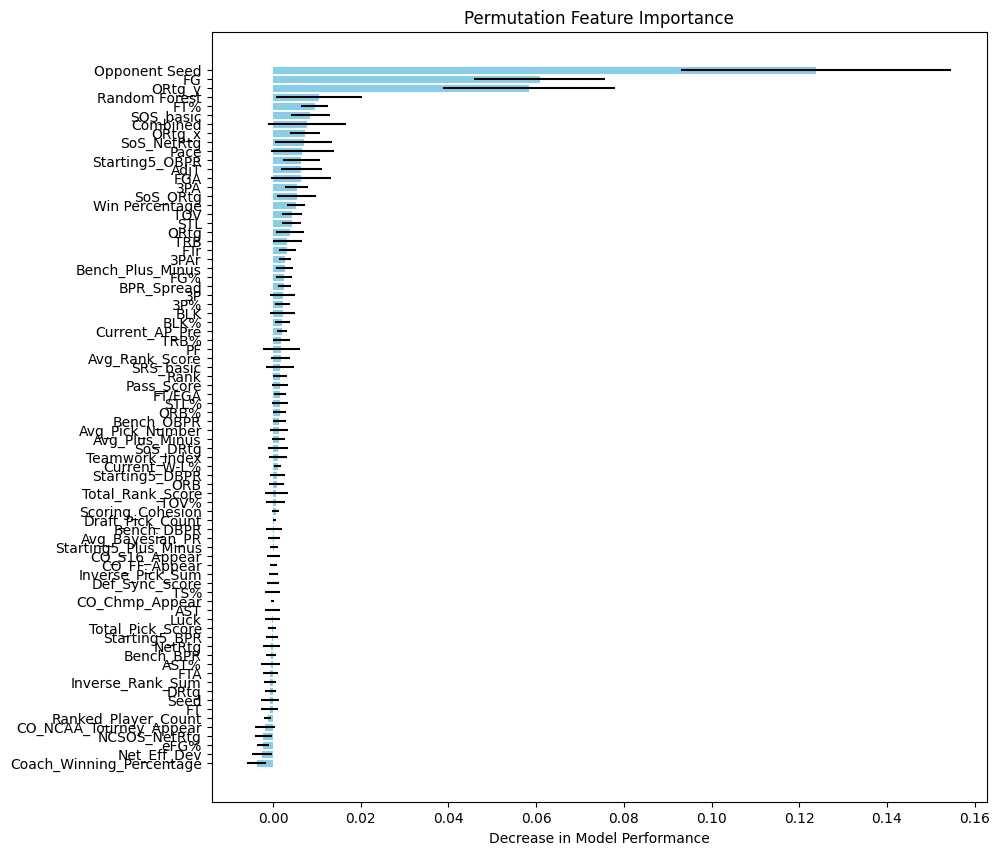

In [48]:
# After selecting your best model and param combo, re-train it on CPU-based arrays
# X_train and X_test should be NumPy arrays, not CuPy
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

best_params = {
    'n_estimators': 500,
    'max_depth': 22,
    'learning_rate': 0.0075,
    'subsample': 0.7,
    'colsample_bytree': 0.65
}
# Re-initialize model with best hyperparameters
bracket_XGBoost = XGBRegressor(
    tree_method='hist',
    device='cpu',
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    **best_params  
)

# Fit on CPU arrays (XGB handles GPU training internally)
bracket_XGBoost.fit(X_train_np, y_train_np)

# ⏳ Run permutation importance
result = permutation_importance(
    bracket_XGBoost,
    X_test_np,
    y_test_np,
    n_repeats=100,
    random_state=42,
    n_jobs=-1
)

# 📊 Sort and display top 10 features
sorted_idx = np.argsort(result.importances_mean)[::-1]

importance_df = pd.DataFrame({
    "Feature": [feature_names[i] for i in sorted_idx],
    "Mean Importance": result.importances_mean[sorted_idx],
    "Std Dev": result.importances_std[sorted_idx]
})

importance_df = importance_df.round(4)

print(importance_df.to_string(index=False))

# 📈 Plot the results
plt.figure(figsize=(10, 10))
plt.barh(
    [feature_names[i] for i in sorted_idx],
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    color='skyblue'
)
plt.gca().invert_yaxis()
plt.xlabel("Decrease in Model Performance")
plt.title("Permutation Feature Importance")
plt.show()

In [49]:
'''
Going to create an XGBoost Set - All values are going to be .002 or greater away from 0. This gives us Luck, FG%, CO_W-L%, Seed, ORtg_y, Opponent Seed,
FG, Current Round, SoS_NetRtg, FGA, Pace, TRB, SoS_ORtg, PF, AdjT, ORtg_x, 3PA, TOV, FT%, 3PAr, SOS_basic, FTA, FT, Starting5_OBPR, BLK, Current_W-L%,
Starting5_BPR, ORtg, Random Forest, AST, FTr, FT/FGA, NetRtg, Bench_DBPR, TRB%, CO_S16, BLK%, Bench_OBPR.  0.002 was selected as I wanted to get some
of the variables that have an inverse relationship with the score as well.  The top 4 were .002 and above with the highest being at .004.  
'''
XGBoost_features = ['Luck', 'FG%', 'CO_W-L%', 'Seed', 'ORtg_y', 'Opponent Seed', 'FG', 'Current Round', 'SoS_NetRtg', 'FGA', 'Pace', 'TRB', 'SoS_ORtg',
                    '3PAr', 'PF', 'AdjT', 'ORtg_x', '3PA', 'TOV', 'FT%', '3PAr', 'SOS_basic', 'FTA', 'FT', 'Starting5_OBPR', 'BLK', 'Current_W-L%', 
                    'Starting5_BPR', 'ORtg', 'Random Forest', 'AST', 'FTr', 'FT/FGA', 'NetRtg', 'Bench_DBPR', 'TRB%', 'CO_S16', 'BLK%', 'Bench_OBPR',
                    'Year', 'Score', 'Team']

XGBoost_features_ds = bracket_data_set[round_tend_analysis_features]

# Create Test and Train Sets
test_XGBoost_features_ds = XGBoost_features_ds[(XGBoost_features_ds["Year"] == 2025)]
train_XGBoost_features_ds = XGBoost_features_ds[(XGBoost_features_ds["Year"] < 2025)]

# X and Y / Test and Train
dropped_columns_train = test_XGBoost_features_ds[['Year', 'Score', 'Team']]
dropped_columns_test = test_XGBoost_features_ds[['Year', 'Score', 'Team']]
x_train_XGBoost_features_ds = train_XGBoost_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_XGBoost_features_ds = train_XGBoost_features_ds['Score']
x_test_XGBoost_features_ds = test_XGBoost_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_XGBoost_features_ds = test_XGBoost_features_ds['Score']

X_train = x_train_XGBoost_features_ds
X_test = x_test_XGBoost_features_ds
y_train = y_train_XGBoost_features_ds
y_test = y_test_XGBoost_features_ds

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1,
    n_estimators = 500,
    max_depth = 22,
    learning_rate = .0075,
    subsample = 0.7,
    colsample_bytree = 0.65
)

# Train using the cupy data
xgb_model.fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
preds = xgb_model.predict(X_test_gpu)
# MSE calculation
mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
preds_gpu = cp.array(preds)
ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Final GPU MSE:", mse)
print("Final GPU R2:", r2 )

#Final GPU MSE: 94.25902663438833
#Final GPU R2: 0.3531848844073662

Final GPU MSE: 88.77306762179872
Final GPU R2: 0.356641087626666


In [50]:
# X and Y / Test and Train
dropped_columns_train = test_RF_features_ds[['Year', 'Score', 'Team']]
dropped_columns_test = test_RF_features_ds[['Year', 'Score', 'Team']]
x_train_RF_features_ds = train_RF_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_RF_features_ds = train_RF_features_ds['Score']
x_test_RF_features_ds = test_RF_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_RF_features_ds = test_RF_features_ds['Score']

X_train = x_train_RF_features_ds
X_test = x_test_RF_features_ds
y_train = y_train_RF_features_ds
y_test = y_test_RF_features_ds
# 17 features

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model_RF = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1,
    n_estimators = 500,
    max_depth = 22,
    learning_rate = .0075,
    subsample = 0.7,
    colsample_bytree = 0.65
)

# Train using the cupy data
xgb_model_RF.fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
preds = xgb_model_RF.predict(X_test_gpu)
# MSE calculation
mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
preds_gpu = cp.array(preds)
ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Final GPU MSE:", mse)
print("Final GPU R2:", r2 )

#Final GPU MSE: 94.25902663438833
#Final GPU R2: 0.3531848844073662

Final GPU MSE: 88.77306762179872
Final GPU R2: 0.356641087626666


In [51]:
# Going to work the Linear Features next and see how that comes out
x_train_linear_feature_importance_ds = train_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_linear_feature_importance_ds = train_linear_feature_importance_ds['Score']
x_test_linear_feature_importance_ds = test_linear_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_linear_feature_importance_ds = test_linear_feature_importance_ds['Score']

X_train = x_train_linear_feature_importance_ds
X_test = x_test_linear_feature_importance_ds
y_train = y_train_linear_feature_importance_ds
y_test = y_test_linear_feature_importance_ds
# 15 features

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model_linear = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1,
    n_estimators = 500,
    max_depth = 22,
    learning_rate = .0075,
    subsample = 0.7,
    colsample_bytree = 0.65
)

# Train using the cupy data
xgb_model_linear.fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
preds = xgb_model_linear.predict(X_test_gpu)
# MSE calculation
mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
preds_gpu = cp.array(preds)
ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Final GPU MSE:", mse)
print("Final GPU R2:", r2 )

#Final GPU MSE: 95.06797531218851
#Final GPU R2: 0.3476337955491142

Final GPU MSE: 92.80681225743221
Final GPU R2: 0.3274076091506368


In [52]:
# Going to work the Round Analysis Features next and see how that comes out
x_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_round_tend_analysis_features_ds = train_round_tend_analysis_features_ds['Score']
x_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_round_tend_analysis_features_ds = test_round_tend_analysis_features_ds['Score']

X_train = x_train_round_tend_analysis_features_ds
X_test = x_test_round_tend_analysis_features_ds
y_train = y_train_round_tend_analysis_features_ds
y_test = y_test_round_tend_analysis_features_ds
# 30 features

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model_round = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1,
    n_estimators = 500,
    max_depth = 22,
    learning_rate = .0075,
    subsample = 0.7,
    colsample_bytree = 0.65
)

# Train using the cupy data
xgb_model_round .fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
preds = xgb_model_round .predict(X_test_gpu)
# MSE calculation
mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
preds_gpu = cp.array(preds)
ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Final GPU MSE:", mse)
print("Final GPU R2:", r2 )

#Final GPU MSE: 94.25902663438833
#Final GPU R2: 0.3531848844073662

Final GPU MSE: 88.77306762179872
Final GPU R2: 0.356641087626666


In [53]:
# Going to work the Neural Network Features next and see how that comes out
x_train_NN_feature_importance_ds = train_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_train_NN_feature_importance_ds = train_NN_feature_importance_ds['Score']
x_test_NN_feature_importance_ds = test_NN_feature_importance_ds.drop(columns=['Year', 'Score', 'Team'])
y_test_NN_feature_importance_ds = test_NN_feature_importance_ds['Score']

X_train = x_train_NN_feature_importance_ds
X_test = x_test_NN_feature_importance_ds
y_train = y_train_NN_feature_importance_ds
y_test = y_test_NN_feature_importance_ds
# 12 features

# Create arrays on GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test)
y_test_gpu = cp.array(y_test)


# Initialize the GPU-enabled XGBoost regressor 
xgb_model_NN = XGBRegressor(
    tree_method = 'hist',  
    device = 'cuda',
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1,
    n_estimators = 500,
    max_depth = 22,
    learning_rate = .0075,
    subsample = 0.7,
    colsample_bytree = 0.65
)

# Train using the cupy data
xgb_model_NN.fit(X_train_gpu, y_train_gpu)
# Predict and convert predictions to cupy arrays
preds = xgb_model_NN.predict(X_test_gpu)
# MSE calculation
mse = cp.mean((y_test_gpu - cp.array(preds)) ** 2)
# r2 calculations
preds_gpu = cp.array(preds)
ss_res = cp.sum((y_test_gpu - preds_gpu) ** 2)
ss_tot = cp.sum((y_test_gpu - cp.mean(y_test_gpu)) ** 2)
r2 = 1 - ss_res / ss_tot

print("Final GPU MSE:", mse)
print("Final GPU R2:", r2 )

#Final GPU MSE: 100.38351647999423
#Final GPU R2: 0.3111580064639199

Final GPU MSE: 99.9742583148465
Final GPU R2: 0.27546347312463026
